# The Uber Nairobi Ambulance Perambulation Challenge

Our presentation: https://youtu.be/BGf2DY69piM   https://docs.google.com/presentation/d/1Cbxmjx5trWTcjALX2Jec1VyGwKnCvYTTKtjThnZtSYs/edit#slide=id.g9e886a4034_0_120 

## Starter Notebook and some approach

The goal of this notebook is to provide a brief introduction to the challenge and the data associated with it. It won't go into detail on a solution approach since this is a challenge which may be approached in a number of ways.

In [114]:
import pandas as pd
import geopandas as gpd # For loading the map of road segments

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline

In [116]:
#A function for showing missing data values
def missing_percentage(df):
    
  
    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [4]:
import seaborn as sns
sns.set(rc={'figure.figsize':(30,12)})

# The Challenge

The main dataset for this challenge (in Train.csv) is a record of crashes within Nairobi over 2018-19. Each crash has an associated datetime and location. Let's load the data and take a look.

In [5]:
# Load the data
df = pd.read_csv('Data/Train.csv', parse_dates=['datetime'])
print(df.shape)
df.head()

(6318, 4)


uid            datetime  latitude  longitude
0    1 2018-01-01 00:25:46 -1.188850  36.931382
1    2 2018-01-01 02:02:39 -0.662939  37.208730
2    3 2018-01-01 02:31:49 -0.662939  37.208730
3    4 2018-01-01 03:04:01 -1.288087  36.826583
4    5 2018-01-01 03:58:49 -1.188850  36.931382

In [6]:
missing_percentage(df)

Empty DataFrame
Columns: [Total, Percent]
Index: []

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


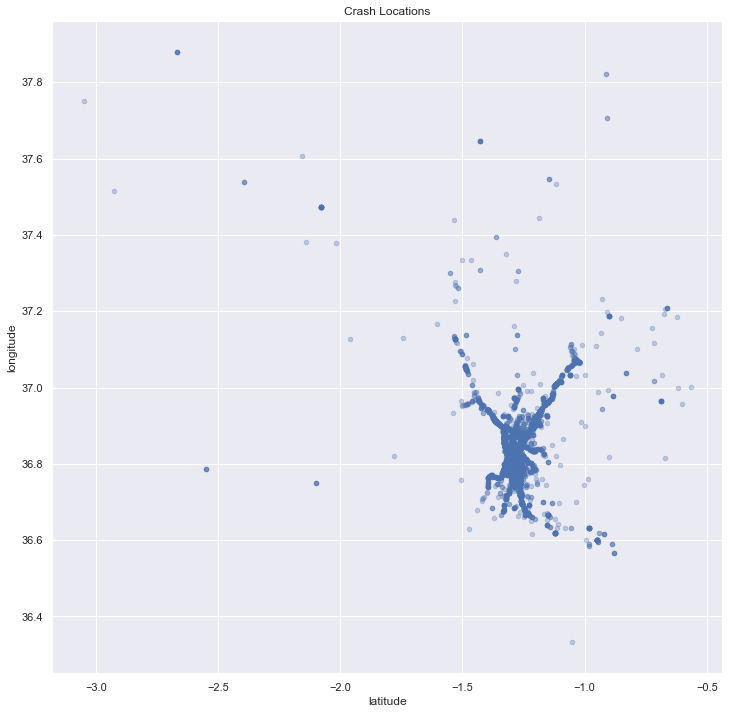

In [7]:

df.plot(x='latitude', y='longitude', kind='scatter', figsize=(12, 12), alpha=0.3, title='Crash Locations')

In [8]:
df['Date'] = pd.to_datetime(df['datetime'].dt.date)

In [9]:
df['Date'].dtypes

dtype('<M8[ns]')

Rather than trying to predict accident locations or the number of accidents in a given timeframe, we are instead asked to come up with an ambulance deployment schedule that will minimise distance travelled. 

This is of course a simplification of the problem, but by solving this you will hopefully develop strategies that can be used going forward.

In [10]:
# View the submission format
ss = pd.read_csv('Data/SampleSubmission.csv', parse_dates=['date'])
ss.head()

date  A0_Latitude  A0_Longitude  A1_Latitude  A1_Longitude  \
0 2019-07-01 00:00:00            0             0            0             0   
1 2019-07-01 03:00:00            0             0            0             0   
2 2019-07-01 06:00:00            0             0            0             0   
3 2019-07-01 09:00:00            0             0            0             0   
4 2019-07-01 12:00:00            0             0            0             0   

   A2_Latitude  A2_Longitude  A3_Latitude  A3_Longitude  A4_Latitude  \
0            0             0            0             0            0   
1            0             0            0             0            0   
2            0             0            0             0            0   
3            0             0            0             0            0   
4            0             0            0             0            0   

   A4_Longitude  A5_Latitude  A5_Longitude  
0             0            0             0  
1             0            0             0  
2             0            0             0  
3             0            0             0  
4             0            0             0

# Scoring

You can re-create the scoring process by creating your own test set and using the following function:

In [11]:
def score(sub, ref):
    total_distance = 0
    for date, c_lat, c_lon in ref[['datetime', 'latitude', 'longitude']].values:
        row = sub.loc[sub.date < date].tail(1) # Prior to Oct 2 this was incorrectly .head(1)
        dists = []
        for a in range(6):
            dist = ((c_lat - row[f'A{a}_Latitude'].values[0])**2+(c_lon - row[f'A{a}_Longitude'].values[0])**2)**0.5 
            dists.append(dist)
        total_distance += min(dists)
    return total_distance

In [12]:
# Example:

# Test set
reference = df.loc[df.datetime > '2019-01-01'] # Using 2019 as our test set

# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')

# Create submission dataframe
sub = pd.DataFrame({
    'date':dates
})
for ambulance in range(6):
    sub['A'+str(ambulance)+'_Latitude'] = 0
    sub['A'+str(ambulance)+'_Longitude'] = 0

# Place an ambulance in the center of the city:
sub['A'+str(ambulance)+'_Latitude'] = 36.82
sub['A'+str(ambulance)+'_Longitude'] = -1.3



score(sub, reference)

70886.38526378157

This scoring function can be used for local testing without needing to submit on Zindi. Lower is better. Experiment with specifying set locations for all 6 ambulances, and see how low you can get your score.

# Weather Data

Some weatehr variables form the GFS dataset are provided, covering the greater Nairobi area. Let's take a quick look at the dataset before moving on:

In [13]:
weather = pd.read_csv('Data/Weather_Nairobi_Daily_GFS.csv', parse_dates=['Date'])
weather['Date'] = pd.to_datetime(weather['Date'].dt.date)
weather.head()

Date  precipitable_water_entire_atmosphere  \
0 2018-01-01                             24.100000   
1 2018-01-02                             27.362288   
2 2018-01-03                             30.246618   
3 2018-01-04                             33.010689   
4 2018-01-05                             27.250372   

   relative_humidity_2m_above_ground  specific_humidity_2m_above_ground  \
0                          72.700005                           0.009560   
1                          74.900002                           0.010463   
2                          86.599998                           0.011930   
3                          90.900002                           0.012780   
4                          82.413353                           0.011392   

   temperature_2m_above_ground  u_component_of_wind_10m_above_ground  \
0                    15.161493                             -0.012186   
1                    16.047998                              0.314543   
2                    15.838525                             -0.282732   
3                    16.169244                              0.211572   
4                    15.923456                              1.047275   

   v_component_of_wind_10m_above_ground  
0                             -0.933914  
1                             -0.485459  
2                             -0.653965  
3                              0.908123  
4                             -0.037742

In [14]:
#downoloading first preproccesed data

preprocessed_df = pd.read_csv('Data/preprocessed_df.csv', parse_dates=['datetime'])
preprocessed_df['Date'] = pd.to_datetime(preprocessed_df['datetime'].apply(lambda x: x.date()))
df_with_weather = pd.merge(preprocessed_df, weather, on = 'Date')

In [15]:
missing_percentage(weather)

Total   Percent
v_component_of_wind_10m_above_ground      3  0.410397
u_component_of_wind_10m_above_ground      3  0.410397
temperature_2m_above_ground               3  0.410397
specific_humidity_2m_above_ground         3  0.410397
relative_humidity_2m_above_ground         3  0.410397
precipitable_water_entire_atmosphere      3  0.410397

# Road Survey Data

The road survey data contains many different measurements for each surveyed road segment. Unfortunately we can't access the raw data, and must work 'in the dark' in terms of what the column headings mean. However, the naming convention does at least show which columns may be related.

To locate the road segments geographically, a geojson file is provided. Here is an example of merging the survey data with the segments and visualizing the result.

In [16]:
# Load the survey data
road_surveys = pd.read_csv('Data/Segment_info.csv')
road_surveys.head()

segment_id  side  25_48  79_76  79_65  79_39  28_78_50  55_90  26_76  92_30  \
0      176_2     1      3      0      3      3       0.0     11      0      1   
1      176_2     2      3      0      3      3       0.0     11      0      1   
2       95_1     1      3      0      3      3       0.0     14      0      3   
3       95_1     2      3      0      3      3       0.0     14      0      3   
4      144_7     1      1      0      4      3       0.0      5      0      3   

   ...  80_97_61_65_11  80_97_61_65_12  80_97_61_65_15  80_97_61_65_16  \
0  ...             0.0             1.0             0.0             0.0   
1  ...             0.0             1.0             0.0             0.0   
2  ...             NaN             NaN             NaN             NaN   
3  ...             NaN             NaN             NaN             NaN   
4  ...             0.0             1.0             0.0             0.0   

   80_97_61_39_0  80_97_61_39_10  80_97_61_39_11  80_97_61_39_12  \
0            0.0             0.0             0.0             1.0   
1            0.0             0.0             0.0             1.0   
2            NaN             NaN             NaN             NaN   
3            NaN             NaN             NaN             NaN   
4            1.0             1.0             0.0             0.0   

   80_97_61_39_15  80_97_61_39_16  
0             0.0             0.0  
1             0.0             0.0  
2             NaN             NaN  
3             NaN             NaN  
4             0.0             0.0  

[5 rows x 228 columns]

In [17]:
missing_percentage(road_surveys)

Total    Percent
75_74            1469  95.700326
77_31_88         1422  92.638436
72_35            1299  84.625407
44_91            1153  75.114007
80_58_47_39       523  34.071661
70_83_57          518  33.745928
80_58_47_65       508  33.094463
80_97_61_39_15    303  19.739414
80_52_39          303  19.739414
80_97_61_39_16    303  19.739414
80_97_61_39_0     303  19.739414
80_97_61_39_10    303  19.739414
80_97_61_39_11    303  19.739414
80_97_61_39_12    303  19.739414
80_98_39          303  19.739414
80_97_61_65_10    290  18.892508
80_97_61_65_0     290  18.892508
80_97_61_65_11    290  18.892508
80_97_61_65_12    290  18.892508
80_97_61_65_15    290  18.892508
80_97_61_65_16    290  18.892508
80_93             290  18.892508
80_98_65          290  18.892508
80_52_65          290  18.892508
60_86_50          289  18.827362
28_78_50          289  18.827362
37_83               9   0.586319

In [18]:
# Load the map
road_segment_locs = gpd.read_file('Data/segments_geometry.geojson')
road_segment_locs.head()

segment_id                   road_name  \
0       28_1         accra road-tertiary   
1      137_1         accra road-tertiary   
2      137_2         accra road-tertiary   
3        1_1  airport north road-primary   
4        1_2  airport north road-primary   

                                            geometry  
0  LINESTRING (36.82603 -1.28447, 36.82605 -1.284...  
1  LINESTRING (36.82656 -1.28371, 36.82658 -1.283...  
2  LINESTRING (36.82711 -1.28289, 36.82713 -1.282...  
3  LINESTRING (36.88646 -1.33284, 36.88649 -1.332...  
4  LINESTRING (36.88726 -1.33226, 36.88729 -1.332...

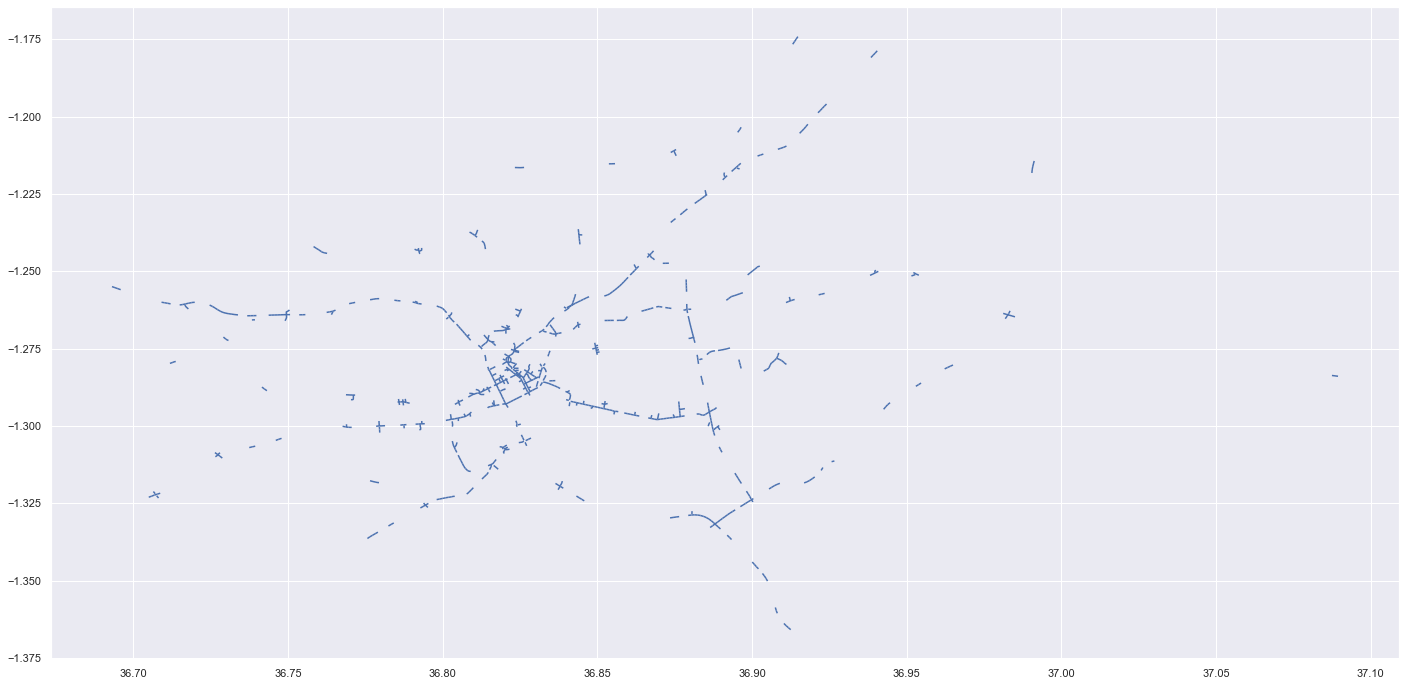

In [19]:
# Because this is a geodataframe, we can plot it
road_segment_locs.plot()

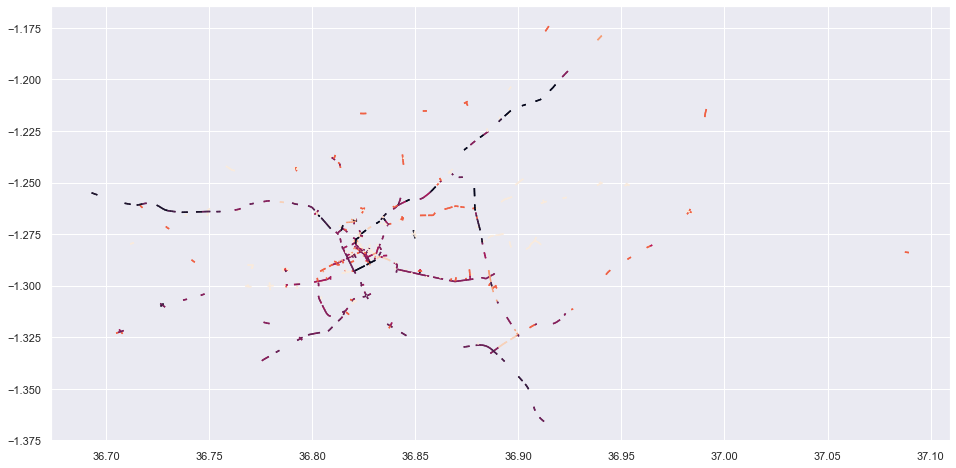

In [20]:
# Let's merge the two and color by one of the survey columns
segments_merged = pd.merge(road_segment_locs, road_surveys, on='segment_id', how='left')
segments_merged.plot(column='55_90', figsize=(20, 8))

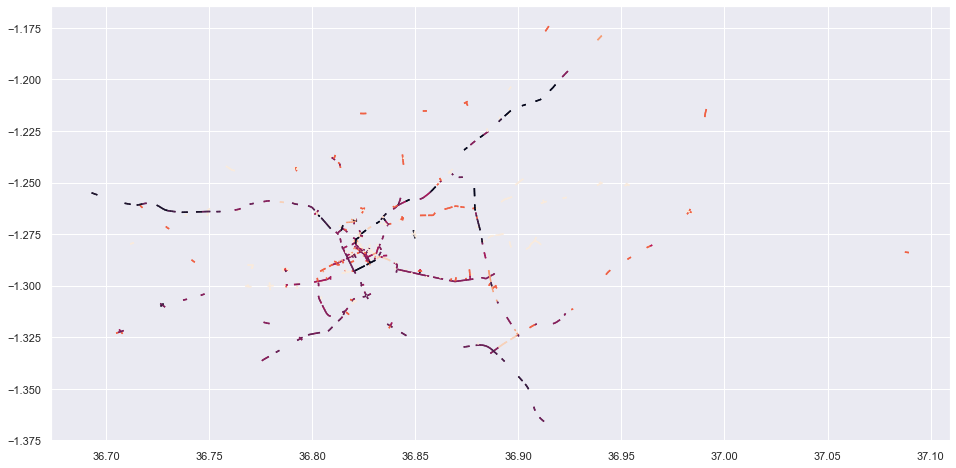

In [21]:
segments_merged.plot(column='55_90', figsize=(20, 8))

Let's see if segment geometry is comparable with the scale of our task. 

In [22]:
from shapely.geometry import LineString, shape
import numpy as np

segments_merged['geometry'] = segments_merged['geometry'].apply(lambda x: np.array(list(shape(x).coords)))
segments_merged['geometry'].apply(lambda x: np.std(x[:, 0])).max()

/Users/dmitrii/opt/anaconda3/lib/python3.7/site-packages/geopandas/geodataframe.py:852: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


0.0005350749622266016

We can see that the length of the biggest road segment is almost 1000 times smaller than the scale of the roadmap. So it's reasonable to store just a mean instead of all the dots in segment geometry. 

In [23]:
segments_merged['geometry']

0       [[36.8260292, -1.2844709], [36.82604954936898,...
1       [[36.8260292, -1.2844709], [36.82604954936898,...
2       [[36.826555607177916, -1.283708049463544], [36...
3       [[36.826555607177916, -1.283708049463544], [36...
4       [[36.82710646622482, -1.282894632316389], [36....
                              ...                        
1530    [[36.73084397155258, -1.263738538644242], [36....
1531    [[36.73182344883697, -1.263880492690996], [36....
1532    [[36.73182344883697, -1.263880492690996], [36....
1533    [[36.73280363504675, -1.264017183907], [36.732...
1534    [[36.73280363504675, -1.264017183907], [36.732...
Name: geometry, Length: 1535, dtype: object

In [24]:
segments_merged['geometry'] = segments_merged['geometry'].apply(lambda x: (np.mean(x[:, 0]),
                                                                           np.mean(x[:, 1])))

In [25]:
segments_merged['geometry']

0        (36.82629875530102, -1.2840998134349553)
1        (36.82629875530102, -1.2840998134349553)
2        (36.82683774447851, -1.2833054951364076)
3        (36.82683774447851, -1.2833054951364076)
4        (36.82752897912522, -1.2822652818365998)
                          ...                    
1530     (36.73133351625148, -1.2638107936586465)
1531      (36.73231336879554, -1.263950279403954)
1532      (36.73231336879554, -1.263950279403954)
1533    (36.733295860844514, -1.2640681645803549)
1534    (36.733295860844514, -1.2640681645803549)
Name: geometry, Length: 1535, dtype: object

In [26]:
segments_merged['geometry'].describe()

count                                         1535
unique                                         792
top       (36.82244548416984, -1.2825037058498687)
freq                                             2
Name: geometry, dtype: object

In [27]:
dff = df.copy(deep=True)

In [28]:
dff.head()

uid            datetime  latitude  longitude       Date
0    1 2018-01-01 00:25:46 -1.188850  36.931382 2018-01-01
1    2 2018-01-01 02:02:39 -0.662939  37.208730 2018-01-01
2    3 2018-01-01 02:31:49 -0.662939  37.208730 2018-01-01
3    4 2018-01-01 03:04:01 -1.288087  36.826583 2018-01-01
4    5 2018-01-01 03:58:49 -1.188850  36.931382 2018-01-01

In [29]:
'''
from scipy.spatial.distance import euclidean as edist
from tqdm.notebook import tqdm

df['segment_id'] = df[['longitude', 'latitude']].apply(lambda x: (x[0], x[1]), axis=1)
for i in tqdm(range(df.shape[0])):
    crash_coords = df.iloc[i]['segment_id']
    min_dist = 100
    segment_id = 0
    for j in range(road_segment_locs.shape[0]):
        dots = np.array(list(shape(road_segment_locs.iloc[j]['geometry']).coords))
        distances = [edist(crash_coords, x) for x in dots]
        if min(distances) < min_dist:
            min_dist = min(distances)
            segment_id = road_segment_locs.iloc[j]['segment_id']
    df.loc[df.uid == i+1, 'segment_id'] = segment_id
'''
print("Here we create 'preprocessed_df.csv'")   #but don't spend time on it, probably now it doesn't work, downoloaded above

Here we create 'preprocessed_df.csv'


In [30]:
df1 = pd.read_csv('Data/Train.csv', parse_dates=['datetime'])
df1['Date'] = pd.to_datetime(df['Date'])
weather = pd.read_csv('Data/Weather_Nairobi_Daily_GFS.csv', parse_dates=['Date'])
weather['Date'] = pd.to_datetime(weather['Date'].dt.date)
X = pd.merge(df1,weather, on = 'Date')

In [31]:
df1.head()

uid            datetime  latitude  longitude       Date
0    1 2018-01-01 00:25:46 -1.188850  36.931382 2018-01-01
1    2 2018-01-01 02:02:39 -0.662939  37.208730 2018-01-01
2    3 2018-01-01 02:31:49 -0.662939  37.208730 2018-01-01
3    4 2018-01-01 03:04:01 -1.288087  36.826583 2018-01-01
4    5 2018-01-01 03:58:49 -1.188850  36.931382 2018-01-01

In [32]:
df.head()

uid            datetime  latitude  longitude       Date
0    1 2018-01-01 00:25:46 -1.188850  36.931382 2018-01-01
1    2 2018-01-01 02:02:39 -0.662939  37.208730 2018-01-01
2    3 2018-01-01 02:31:49 -0.662939  37.208730 2018-01-01
3    4 2018-01-01 03:04:01 -1.288087  36.826583 2018-01-01
4    5 2018-01-01 03:58:49 -1.188850  36.931382 2018-01-01

In [33]:
X.shape

(6318, 11)

In [34]:
X["year"] = X.datetime.dt.year
X["month"] = X.datetime.dt.month
X["day"] = X.datetime.dt.day
X["weekday"] = X.datetime.dt.weekday
X['hour'] = X.datetime.dt.hour
X['minute'] = X.datetime.dt.minute

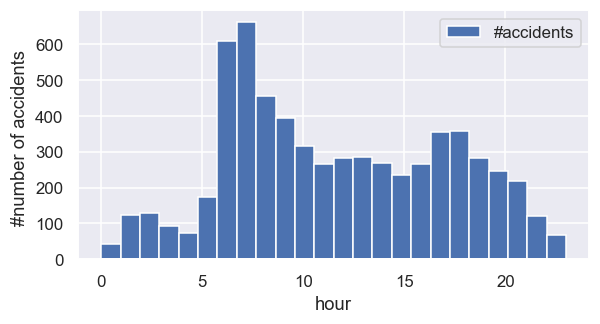

In [35]:
plt.figure(figsize=(6,3), dpi=110)
plt.hist(X.hour, label = '#accidents', bins = 24)

plt.legend()
#plt.title()
plt.ylabel('#number of accidents ')

plt.xlabel('hour')
plt.show()

More cases in work-home trasnfer period

In [36]:
X.head()

uid            datetime  latitude  longitude       Date  \
0    1 2018-01-01 00:25:46 -1.188850  36.931382 2018-01-01   
1    2 2018-01-01 02:02:39 -0.662939  37.208730 2018-01-01   
2    3 2018-01-01 02:31:49 -0.662939  37.208730 2018-01-01   
3    4 2018-01-01 03:04:01 -1.288087  36.826583 2018-01-01   
4    5 2018-01-01 03:58:49 -1.188850  36.931382 2018-01-01   

   precipitable_water_entire_atmosphere  relative_humidity_2m_above_ground  \
0                                  24.1                          72.700005   
1                                  24.1                          72.700005   
2                                  24.1                          72.700005   
3                                  24.1                          72.700005   
4                                  24.1                          72.700005   

   specific_humidity_2m_above_ground  temperature_2m_above_ground  \
0                            0.00956                    15.161493   
1                            0.00956                    15.161493   
2                            0.00956                    15.161493   
3                            0.00956                    15.161493   
4                            0.00956                    15.161493   

   u_component_of_wind_10m_above_ground  v_component_of_wind_10m_above_ground  \
0                             -0.012186                             -0.933914   
1                             -0.012186                             -0.933914   
2                             -0.012186                             -0.933914   
3                             -0.012186                             -0.933914   
4                             -0.012186                             -0.933914   

   year  month  day  weekday  hour  minute  
0  2018      1    1        0     0      25  
1  2018      1    1        0     2       2  
2  2018      1    1        0     2      31  
3  2018      1    1        0     3       4  
4  2018      1    1        0     3      58

In [37]:
q=X.groupby(["Date"])["Date"].count()
X['Date_Num_Acc']=X['Date'].map(q)
#df_road_100=df_road[df_road['count']>100]
#sns.histplot(data=df_road_100['segment_id']).set_title('segment_id distribution (>100)')

In [38]:
q=X.groupby(["Date"])["relative_humidity_2m_above_ground"].mean()
X['Date_Humid']=X['Date'].map(q)

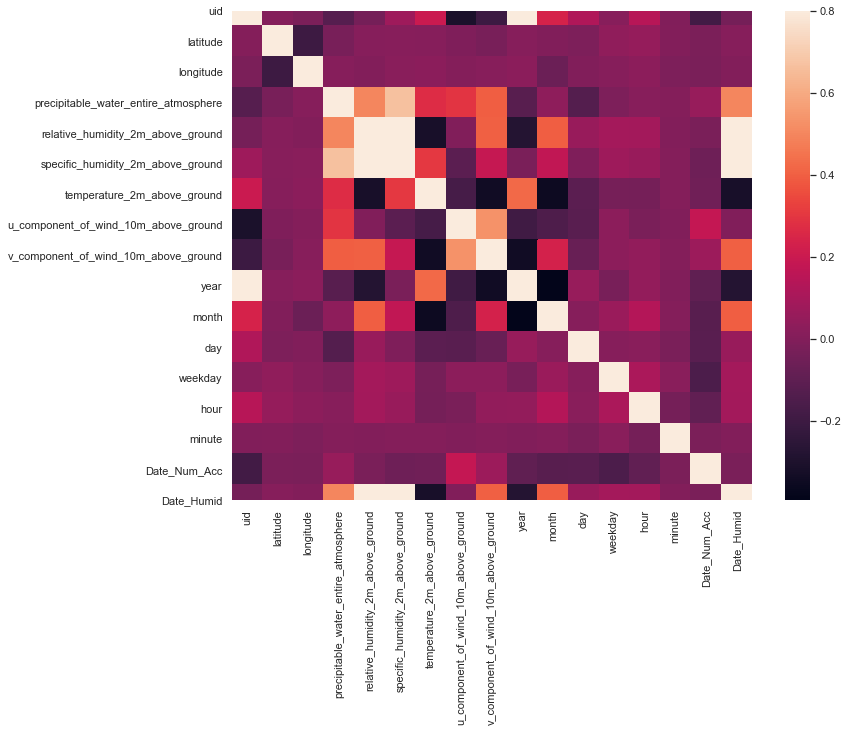

In [39]:
corrmat = X.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.savefig('corr_matrix.png')

In [ ]:
#doesn't show somth intresting

# PCA and TNSE on road survey data

In [ ]:
#initial dimension reducing, then we changed it

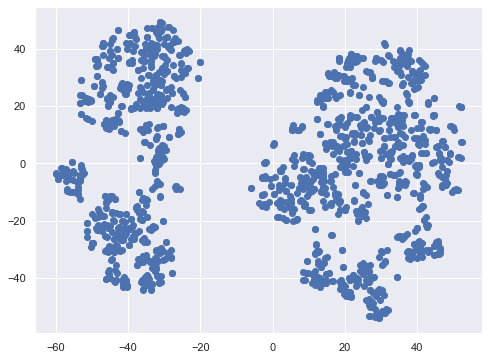

In [40]:
#fill NaN's with mean over the column
for name, column in road_surveys.iteritems():
    road_surveys[name] = road_surveys[name].fillna(column.mean())

road_surveys.head()

from sklearn.manifold import TSNE

tsne = TSNE(random_state=33)
road_surveys_tsne = tsne.fit_transform(road_surveys.loc[:, road_surveys.columns != 'segment_id'])

plt.figure(figsize=(8,6))
plt.scatter(road_surveys_tsne[:, 0], road_surveys_tsne[:, 1])
plt.savefig('tsne.jpg')


from sklearn.decomposition import PCA
pca = PCA(n_components=2)
coordinates_pca = pca.fit_transform(road_surveys.loc[:, road_surveys.columns != 'segment_id'])

[0.48266732 0.05795862 0.04297979 0.03664731 0.02505325]


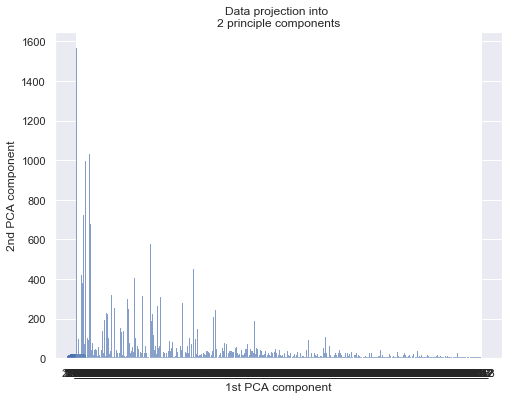

In [41]:
plt.figure(figsize=(8,6))
plt.scatter(coordinates_pca[:, 0], coordinates_pca[:, 1])
plt.xlabel('1st PCA component')
plt.ylabel('2nd PCA component')
plt.title('Data projection into \n2 principle components');
plt.savefig('pca.jpg')

pca = PCA(n_components=5)
coordinates_pca = pca.fit_transform(road_surveys.loc[:, road_surveys.columns != 'segment_id'])
coordinates_pca = pd.DataFrame(data=coordinates_pca)

explained_ratio = pca.explained_variance_ratio_
print(explained_ratio)


road_surveys_pca =  pd.concat([road_surveys['segment_id'], coordinates_pca], axis=1)

road_surveys_pca.head()

segment_ids = road_surveys['segment_id'].unique()
dates = pd.to_datetime(ss['date'].apply(lambda x: x.date()))
dates = dates.unique()
preprocessed_df = pd.read_csv('Data/preprocessed_df.csv', parse_dates=['datetime'])
# we will use some further preproccessed data now
preprocessed_df['Date'] = pd.to_datetime(preprocessed_df['datetime'].apply(lambda x: x.date()))
df_with_weather = pd.merge(preprocessed_df, weather, on = 'Date')
df_with_weather = pd.merge(df_with_weather, road_surveys_pca, on='segment_id')
df_with_weather = df_with_weather.drop(['latitude', 'longitude'], axis=1)
df_with_weather = df_with_weather.drop(['datetime'], axis=1)

df_road = pd.merge(df_with_weather, road_surveys, on='segment_id')

df_road = pd.merge(df_with_weather, road_surveys, on='segment_id')
sns.histplot(data=df_road['segment_id'])

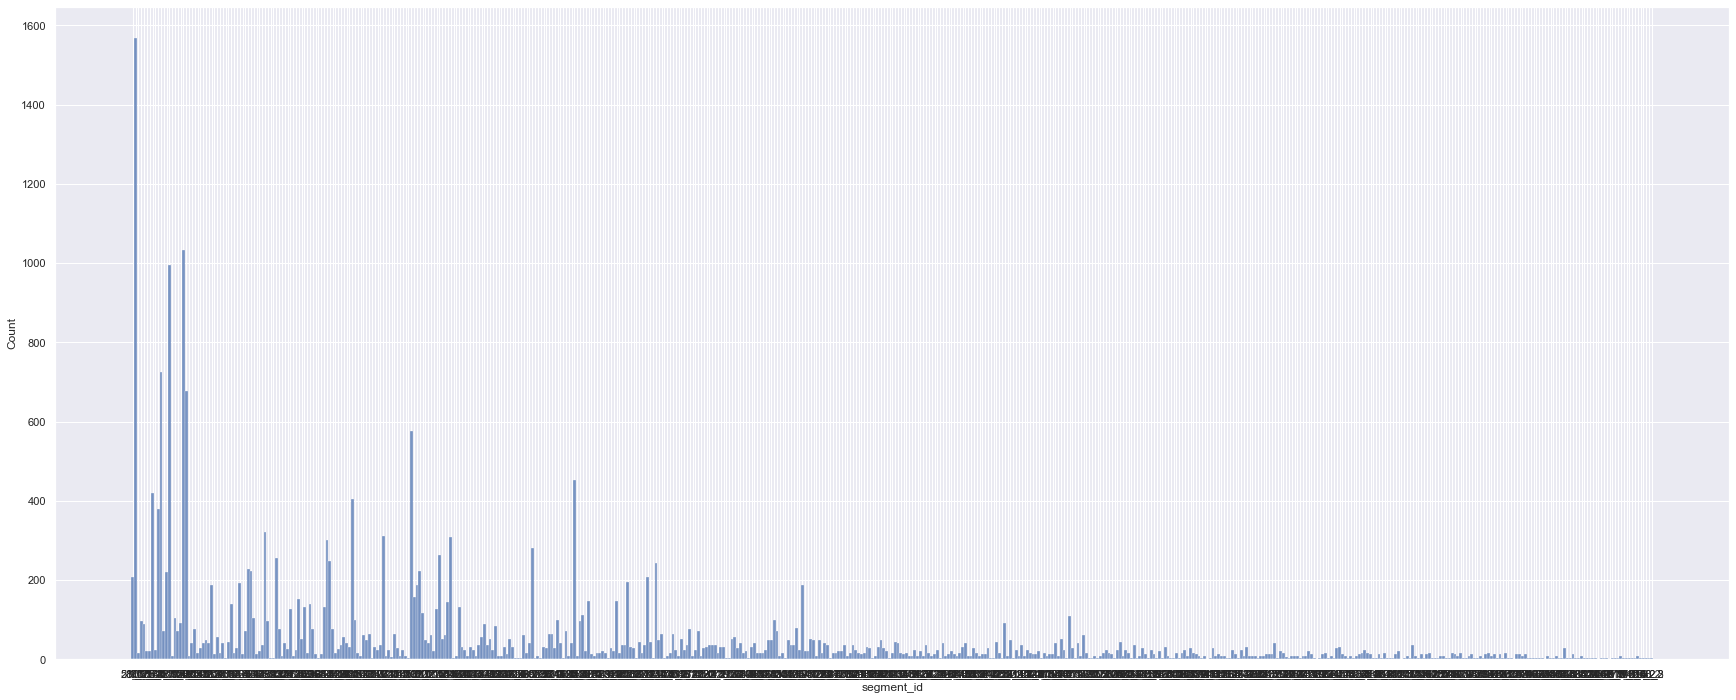

In [42]:
df_road = pd.merge(df_with_weather, road_surveys, on='segment_id')
sns.histplot(data=df_road['segment_id'])

Text(0.5, 1.0, 'segment_id distribution (>100)')

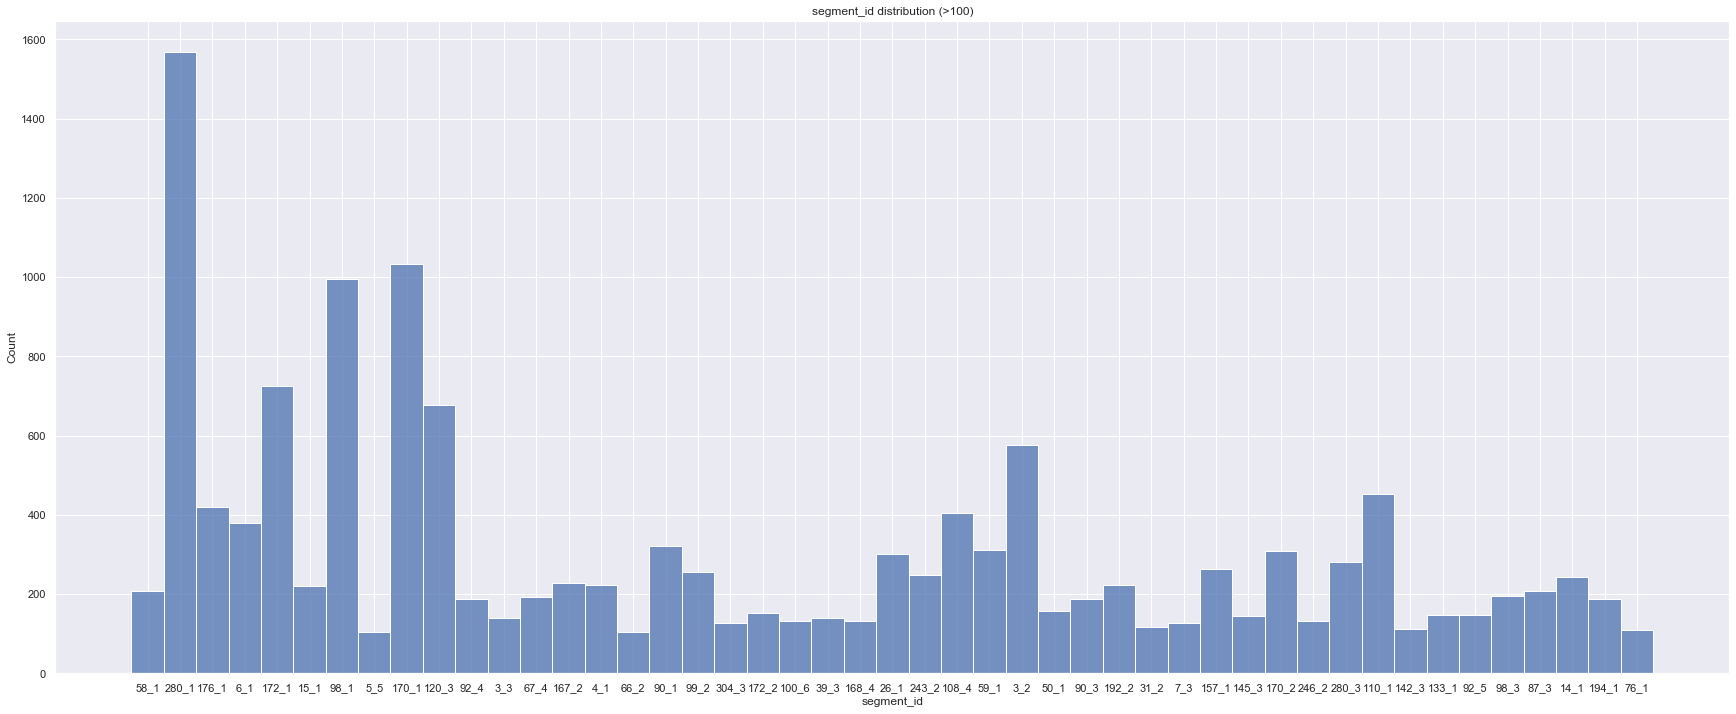

In [43]:
df_with_weather.shape 

q=df_road.groupby(["segment_id"])["segment_id"].count()
df_road['count']=df_road['segment_id'].map(q)
df_road_100=df_road[df_road['count']>100]
sns.histplot(data=df_road_100['segment_id']).set_title('segment_id distribution (>100)')



In [117]:
#distribution by segment_id

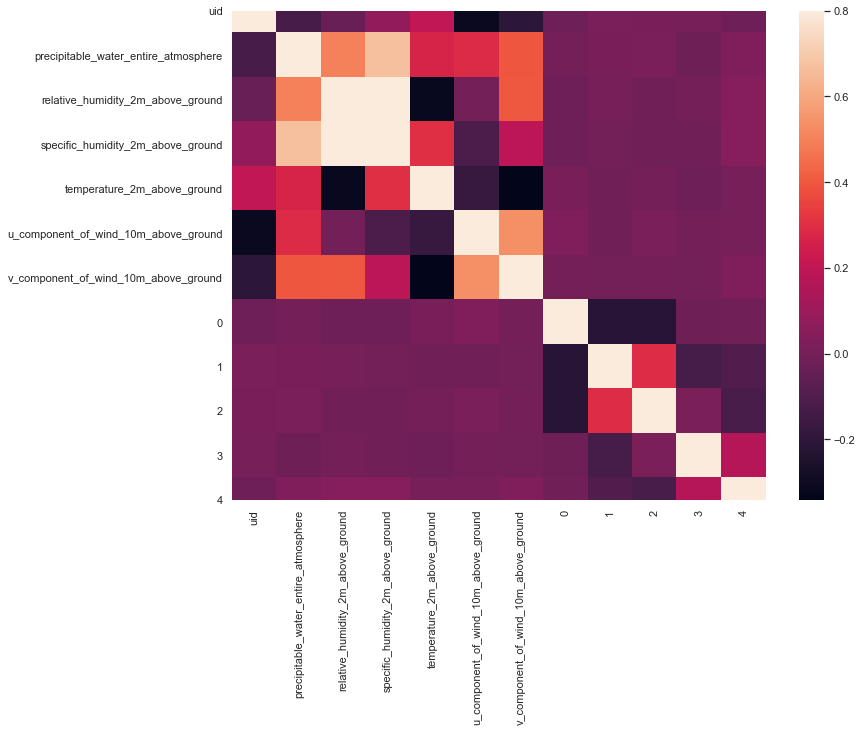

In [44]:
corrmat = df_with_weather.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.savefig('corr_matrix.png')

In [45]:
df_with_weather.shape

(12381, 14)

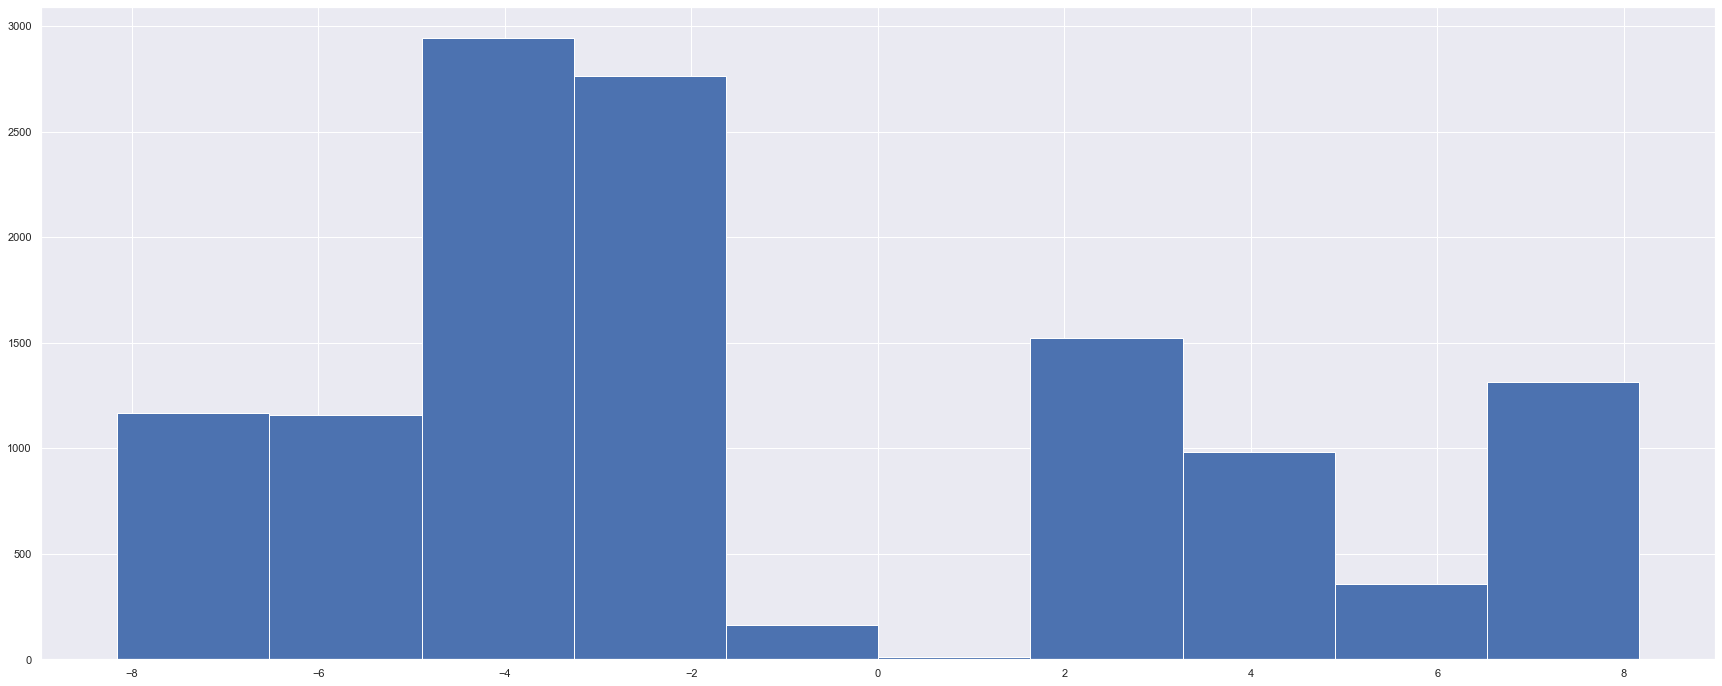

In [46]:
df_with_weather.dtypes



df_with_weather[0].hist()

In [47]:
df_with_weather.head()

uid       Date segment_id  precipitable_water_entire_atmosphere  \
0    1 2018-01-01       58_1                             24.100000   
1    1 2018-01-01       58_1                             24.100000   
2    5 2018-01-01       58_1                             24.100000   
3    5 2018-01-01       58_1                             24.100000   
4   15 2018-01-02       58_1                             27.362288   

   relative_humidity_2m_above_ground  specific_humidity_2m_above_ground  \
0                          72.700005                           0.009560   
1                          72.700005                           0.009560   
2                          72.700005                           0.009560   
3                          72.700005                           0.009560   
4                          74.900002                           0.010463   

   temperature_2m_above_ground  u_component_of_wind_10m_above_ground  \
0                    15.161493                             -0.012186   
1                    15.161493                             -0.012186   
2                    15.161493                             -0.012186   
3                    15.161493                             -0.012186   
4                    16.047998                              0.314543   

   v_component_of_wind_10m_above_ground         0         1         2  \
0                             -0.933914 -2.398031 -3.650033  2.154686   
1                             -0.933914 -2.668842 -3.183330 -0.230703   
2                             -0.933914 -2.398031 -3.650033  2.154686   
3                             -0.933914 -2.668842 -3.183330 -0.230703   
4                             -0.485459 -2.398031 -3.650033  2.154686   

          3         4  
0  0.667469  0.369440  
1 -1.366455  0.687416  
2  0.667469  0.369440  
3 -1.366455  0.687416  
4  0.667469  0.369440

In [48]:
df_with_weather.shape # не такой, как в том доке - хз

(12381, 14)

In [49]:
df_road.shape

(24507, 242)

Text(0.5, 1.0, 'segment_id distribution (>100)')

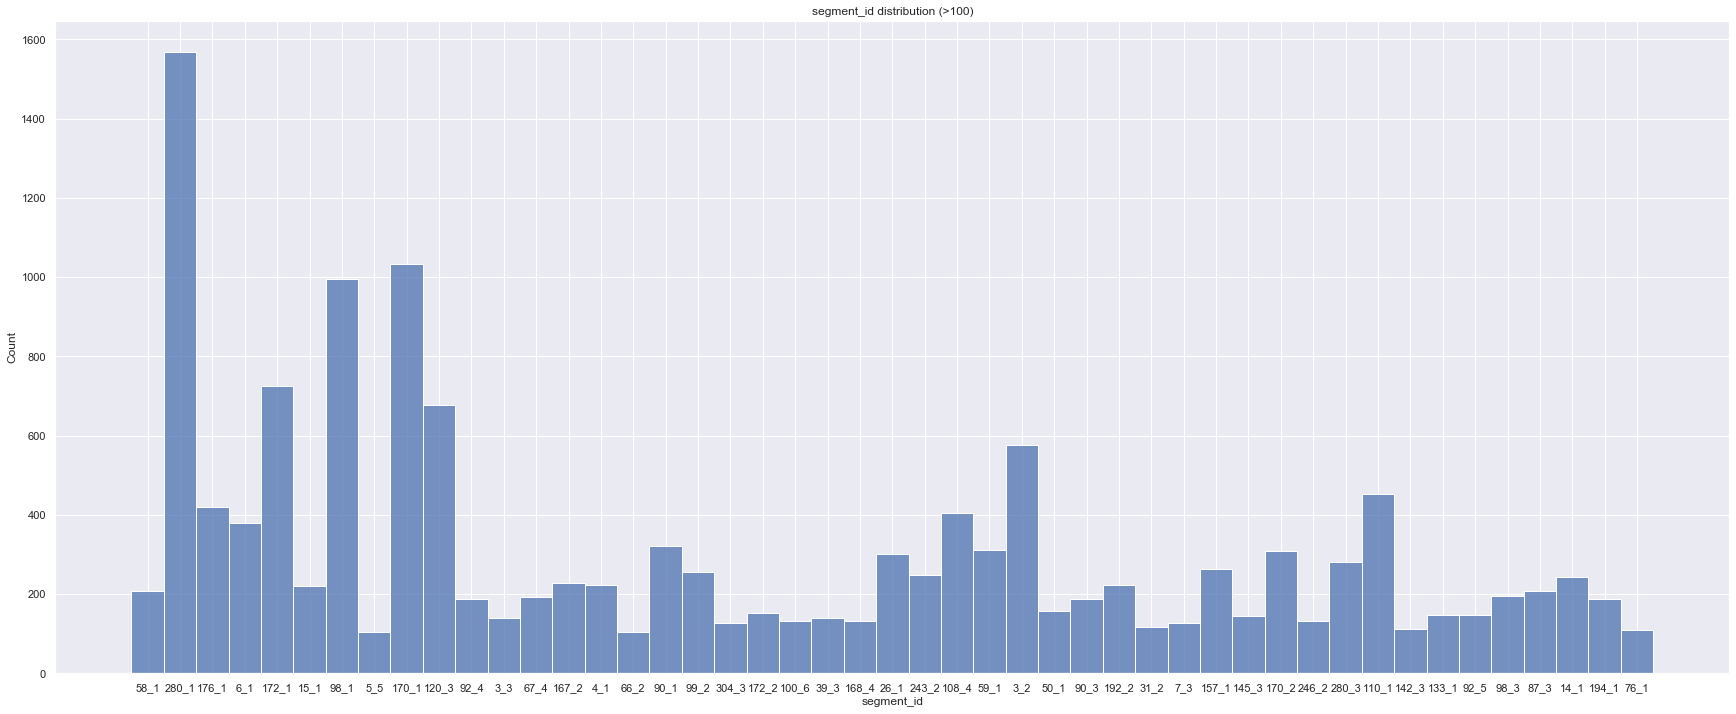

In [50]:
df_with_weather.shape 
q=df_road.groupby(["segment_id"])["segment_id"].count()
df_road['count']=df_road['segment_id'].map(q)
df_road_100=df_road[df_road['count']>100]
sns.histplot(data=df_road_100['segment_id']).set_title('segment_id distribution (>100)')

Now let see on accidendence dependance to PCA label

Text(0.5, 1.0, '#crashes 0')

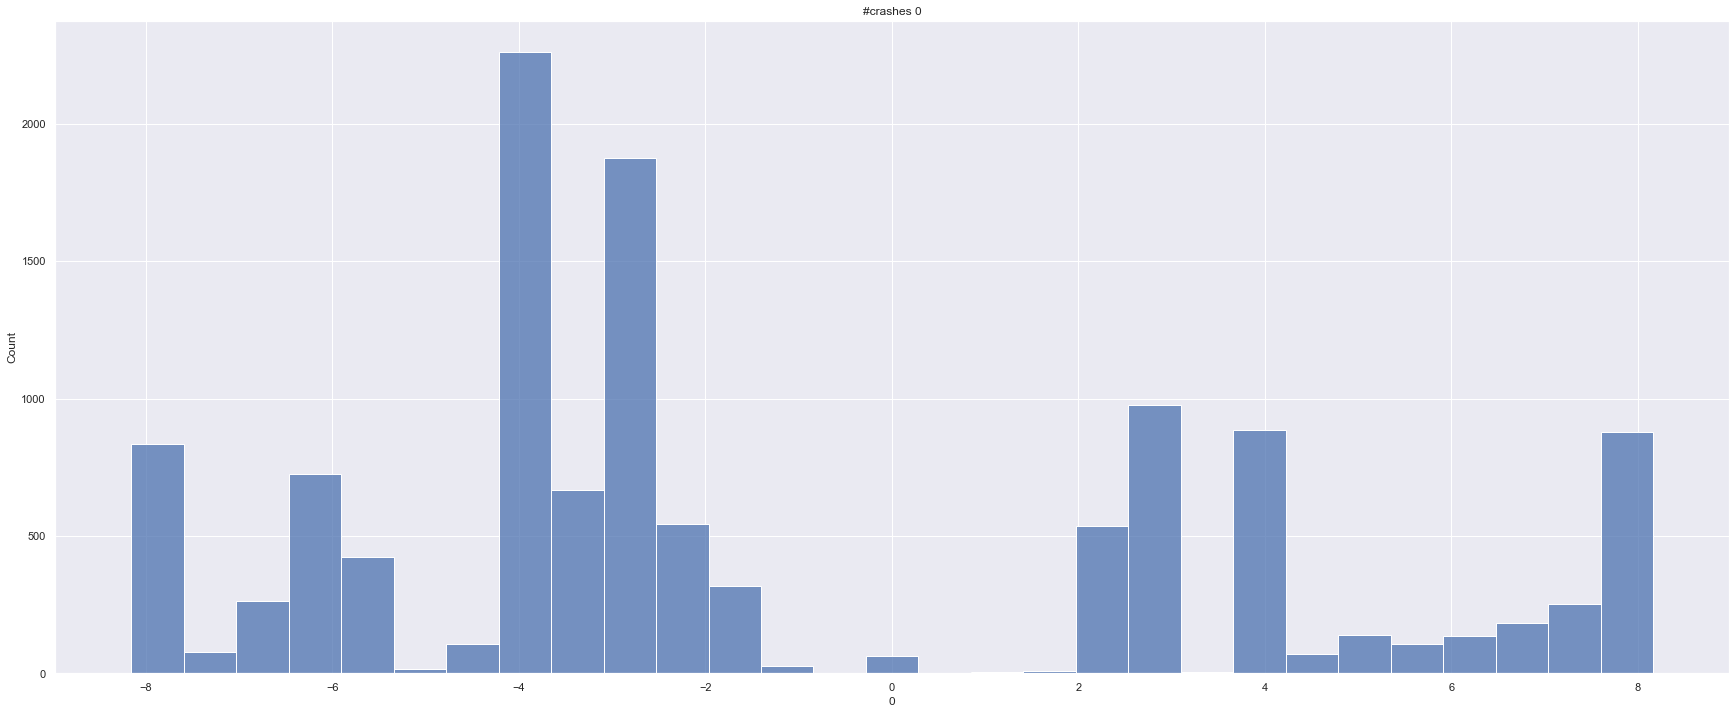

In [51]:
sns.histplot(data=df_with_weather[0]).set_title('#crashes 0')


Text(0.5, 1.0, '#crashes 1')

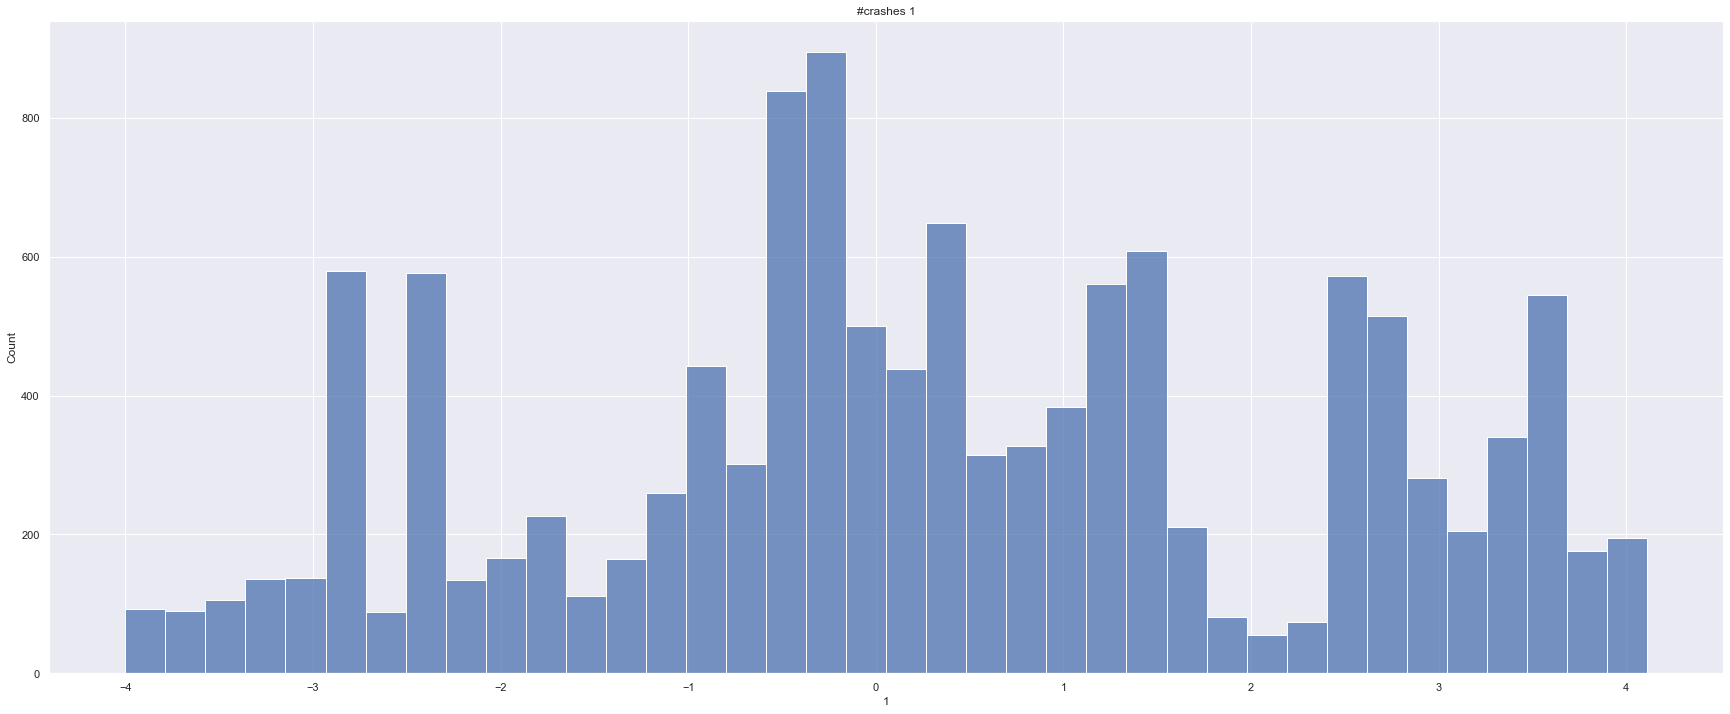

In [52]:
sns.histplot(data=df_with_weather[1]).set_title('#crashes 1')


Text(0.5, 1.0, '#crashes 2')

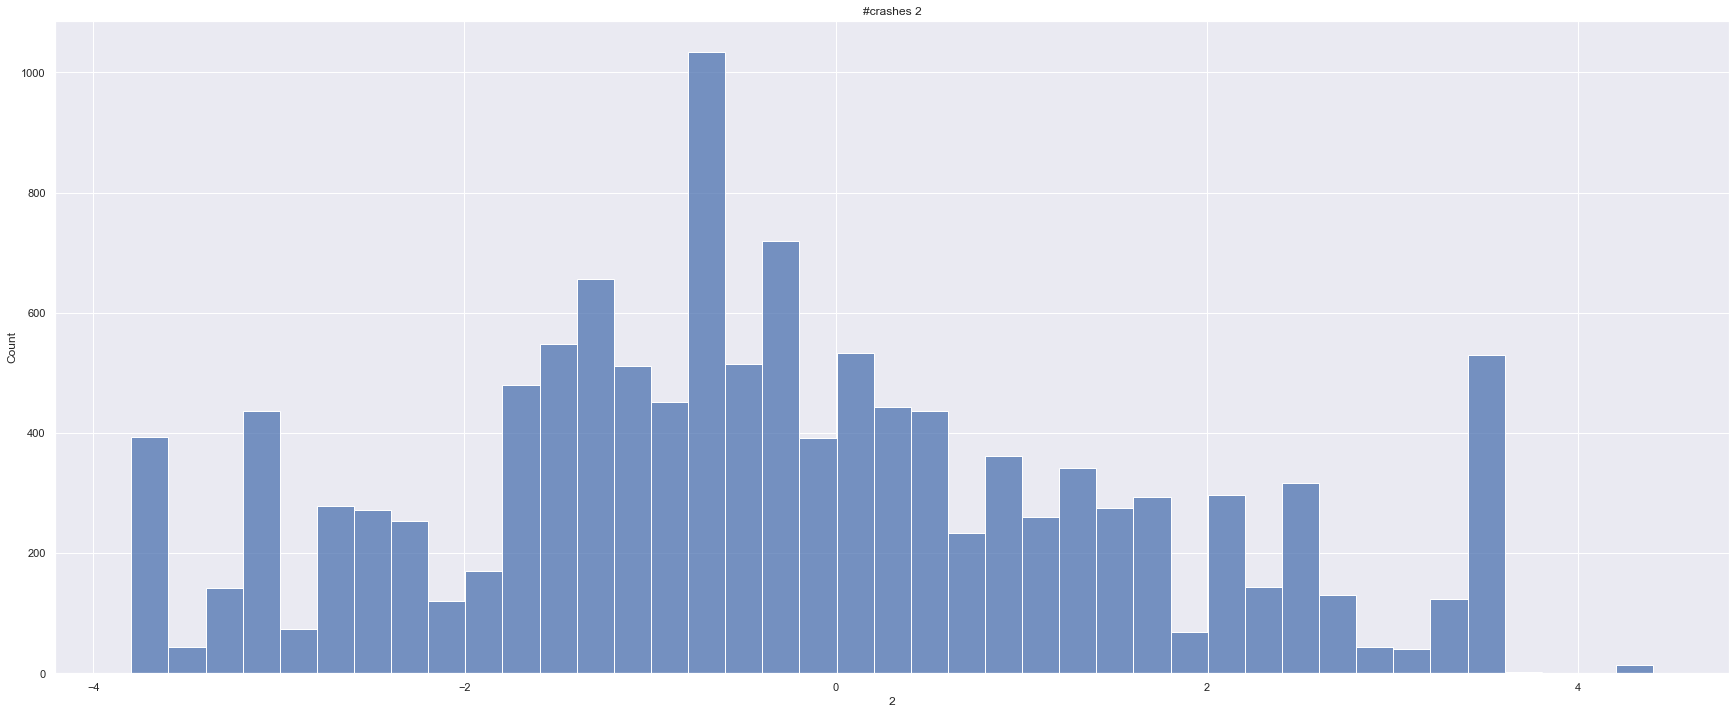

In [53]:
sns.histplot(data=df_with_weather[2]).set_title('#crashes 2')


Text(0.5, 1.0, '#crashes 3')

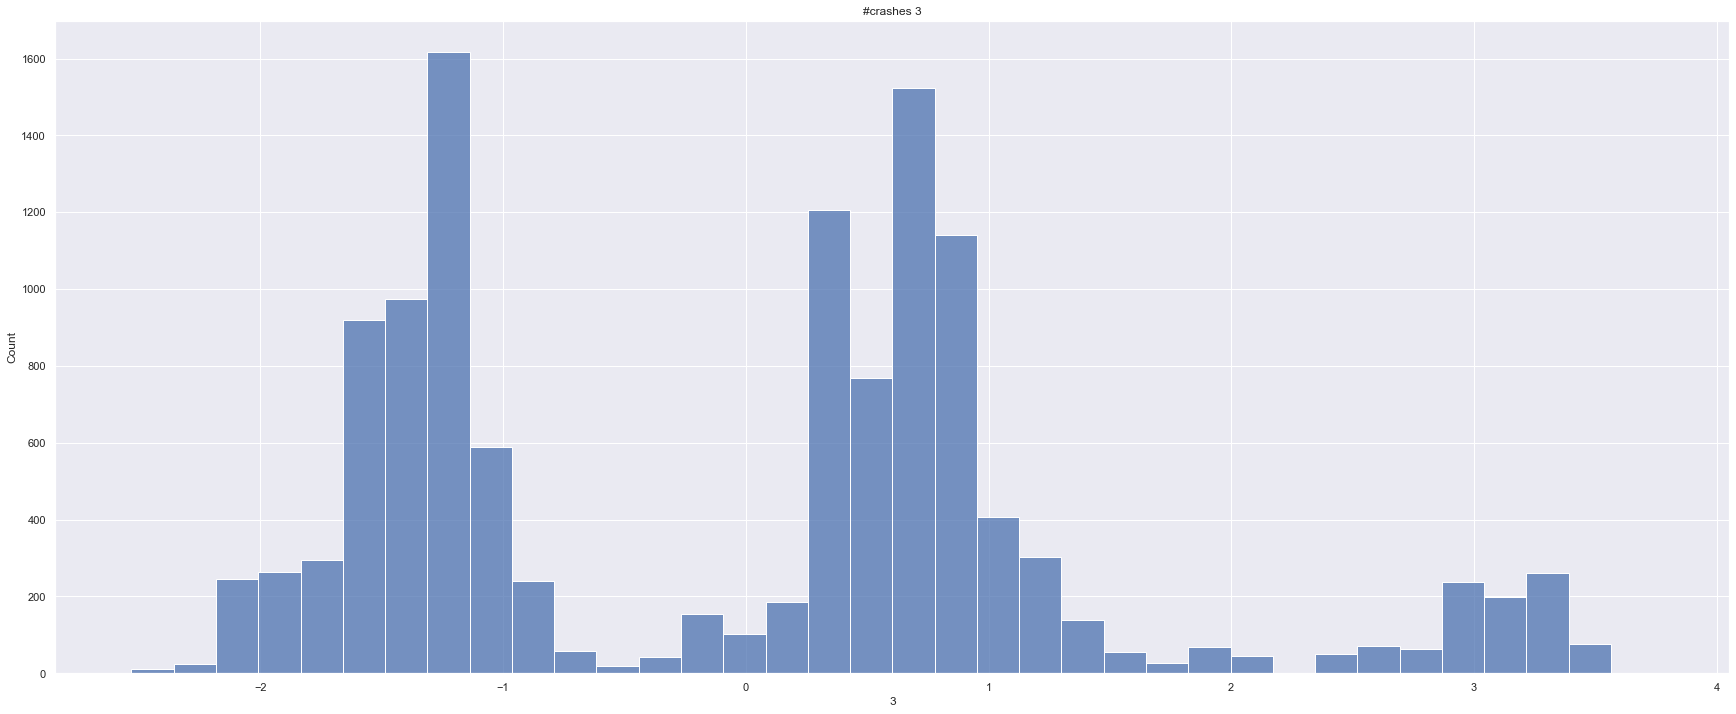

In [54]:
sns.histplot(data=df_with_weather[3]).set_title('#crashes 3')


Text(0.5, 1.0, '#crashes 4')

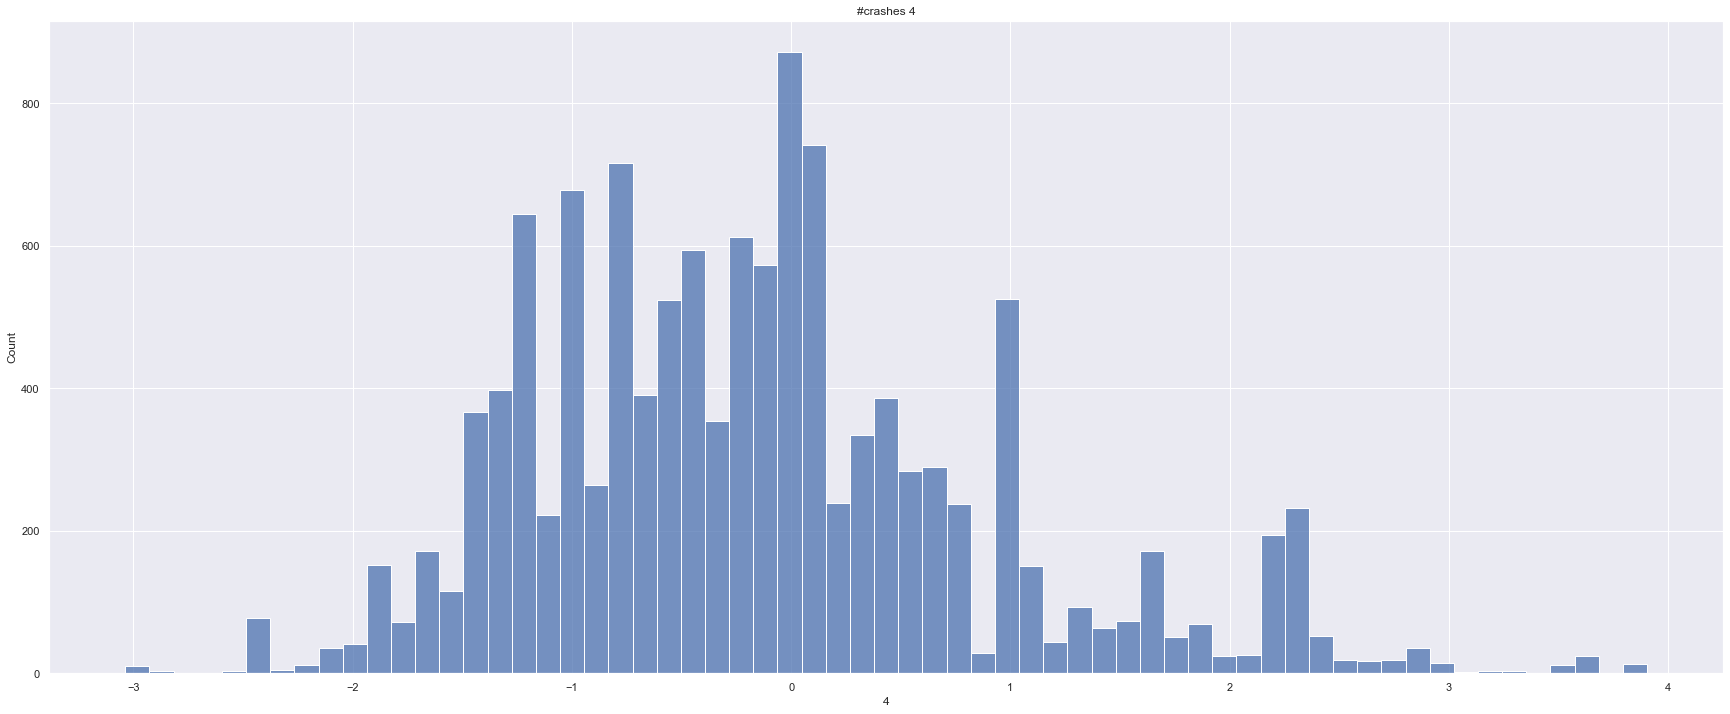

In [55]:
sns.histplot(data=df_with_weather[4]).set_title('#crashes 4')

In [56]:
X.head(3)

uid            datetime  latitude  longitude       Date  \
0    1 2018-01-01 00:25:46 -1.188850  36.931382 2018-01-01   
1    2 2018-01-01 02:02:39 -0.662939  37.208730 2018-01-01   
2    3 2018-01-01 02:31:49 -0.662939  37.208730 2018-01-01   

   precipitable_water_entire_atmosphere  relative_humidity_2m_above_ground  \
0                                  24.1                          72.700005   
1                                  24.1                          72.700005   
2                                  24.1                          72.700005   

   specific_humidity_2m_above_ground  temperature_2m_above_ground  \
0                            0.00956                    15.161493   
1                            0.00956                    15.161493   
2                            0.00956                    15.161493   

   u_component_of_wind_10m_above_ground  v_component_of_wind_10m_above_ground  \
0                             -0.012186                             -0.933914   
1                             -0.012186                             -0.933914   
2                             -0.012186                             -0.933914   

   year  month  day  weekday  hour  minute  Date_Num_Acc  Date_Humid  
0  2018      1    1        0     0      25            13   72.700005  
1  2018      1    1        0     2       2            13   72.700005  
2  2018      1    1        0     2      31            13   72.700005

Text(0.5, 1.0, '#crashes (precipitable_water_entire_atmosphere )')

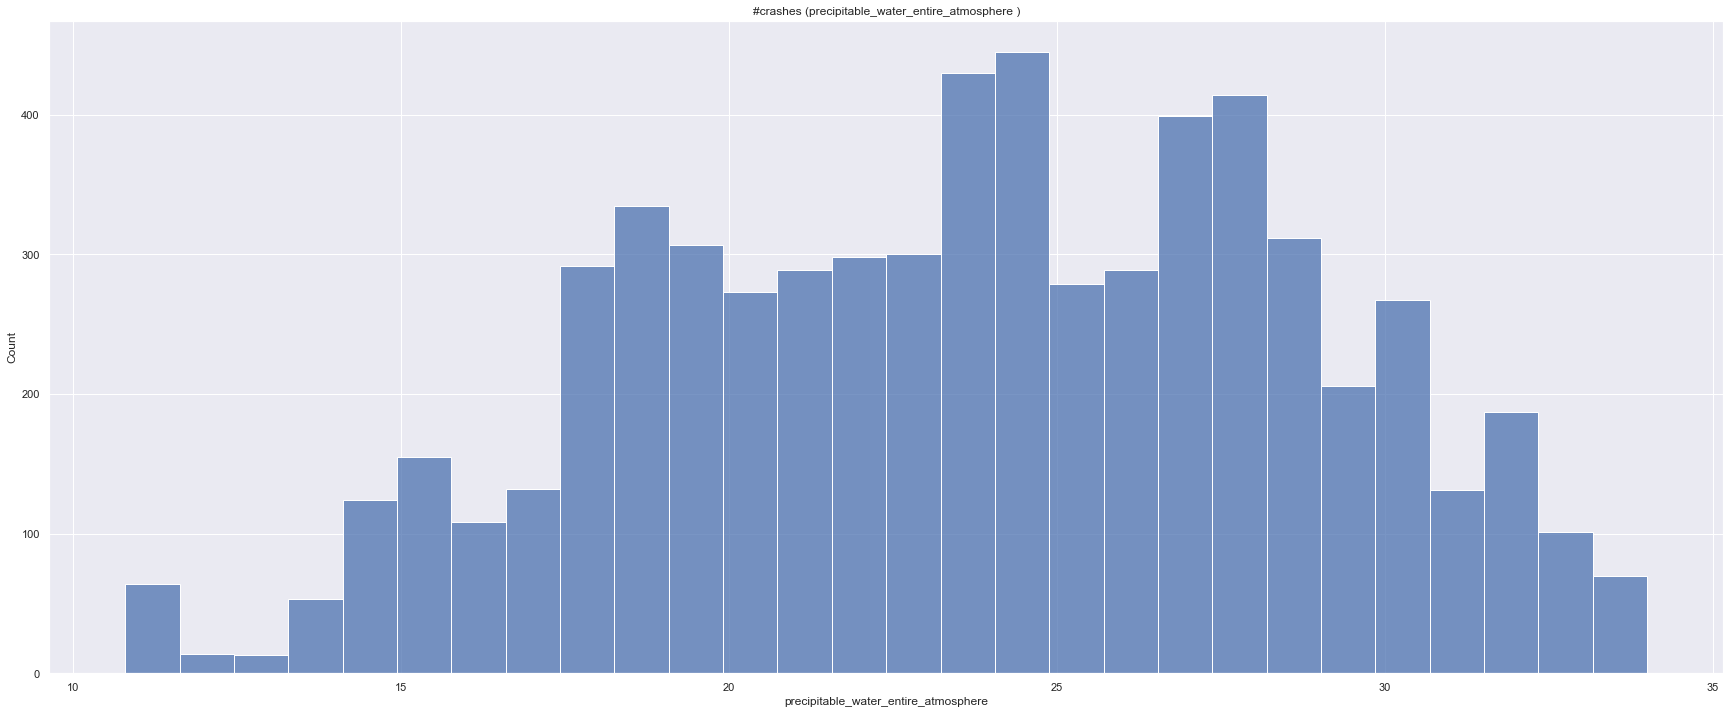

In [57]:
sns.histplot(data=X['precipitable_water_entire_atmosphere']).set_title('#crashes (precipitable_water_entire_atmosphere )')

Text(0.5, 1.0, '#crashes (relative_humidity_2m_above_ground)')

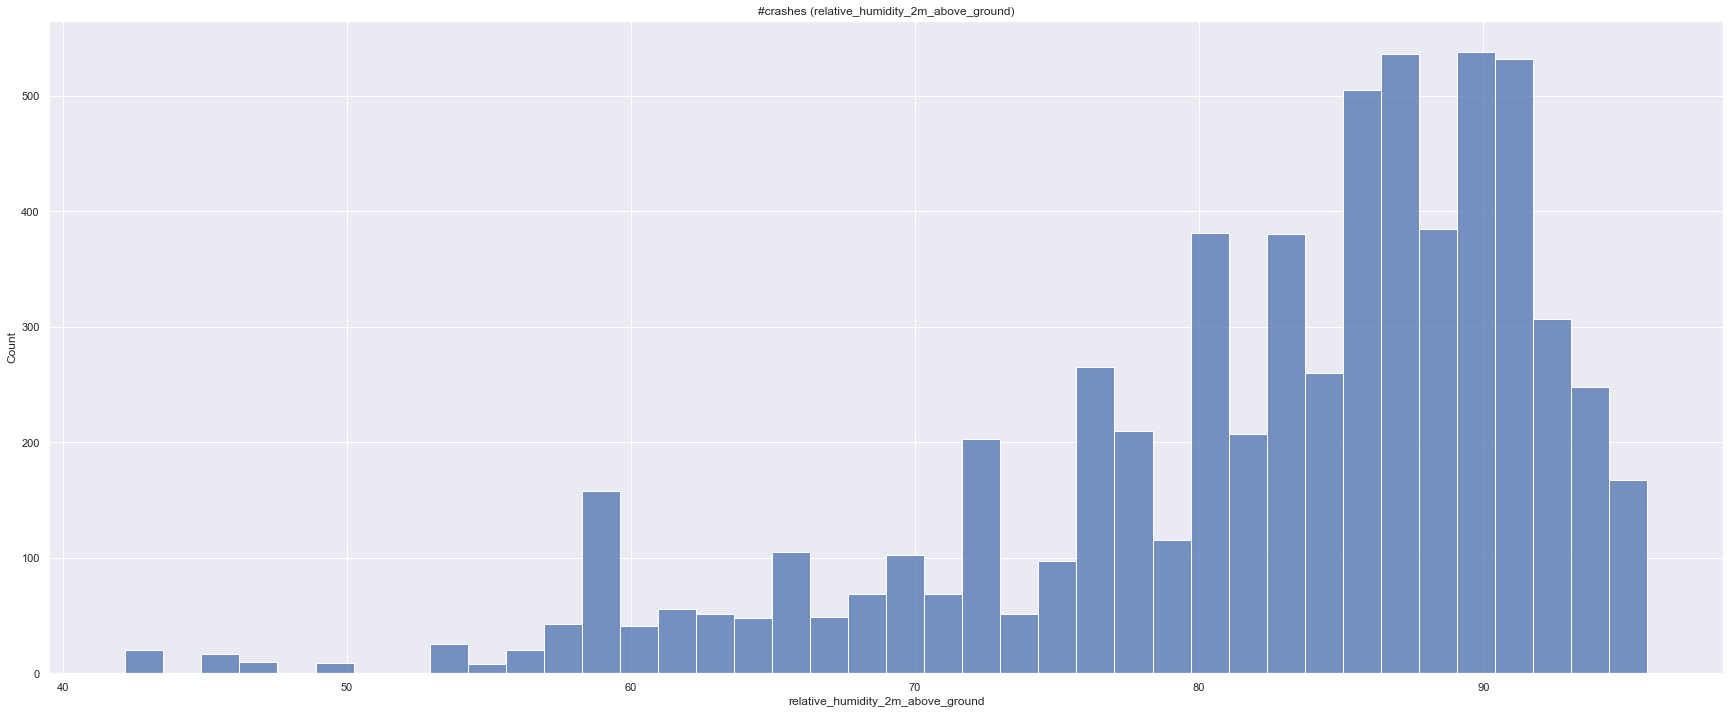

In [58]:
sns.histplot(data=X['relative_humidity_2m_above_ground']).set_title('#crashes (relative_humidity_2m_above_ground)')

Here we can observe, that the bigger relative humidty, the more crashes

In [59]:
#So, humidity>75% might be a feture

We should check humidity dependance on time

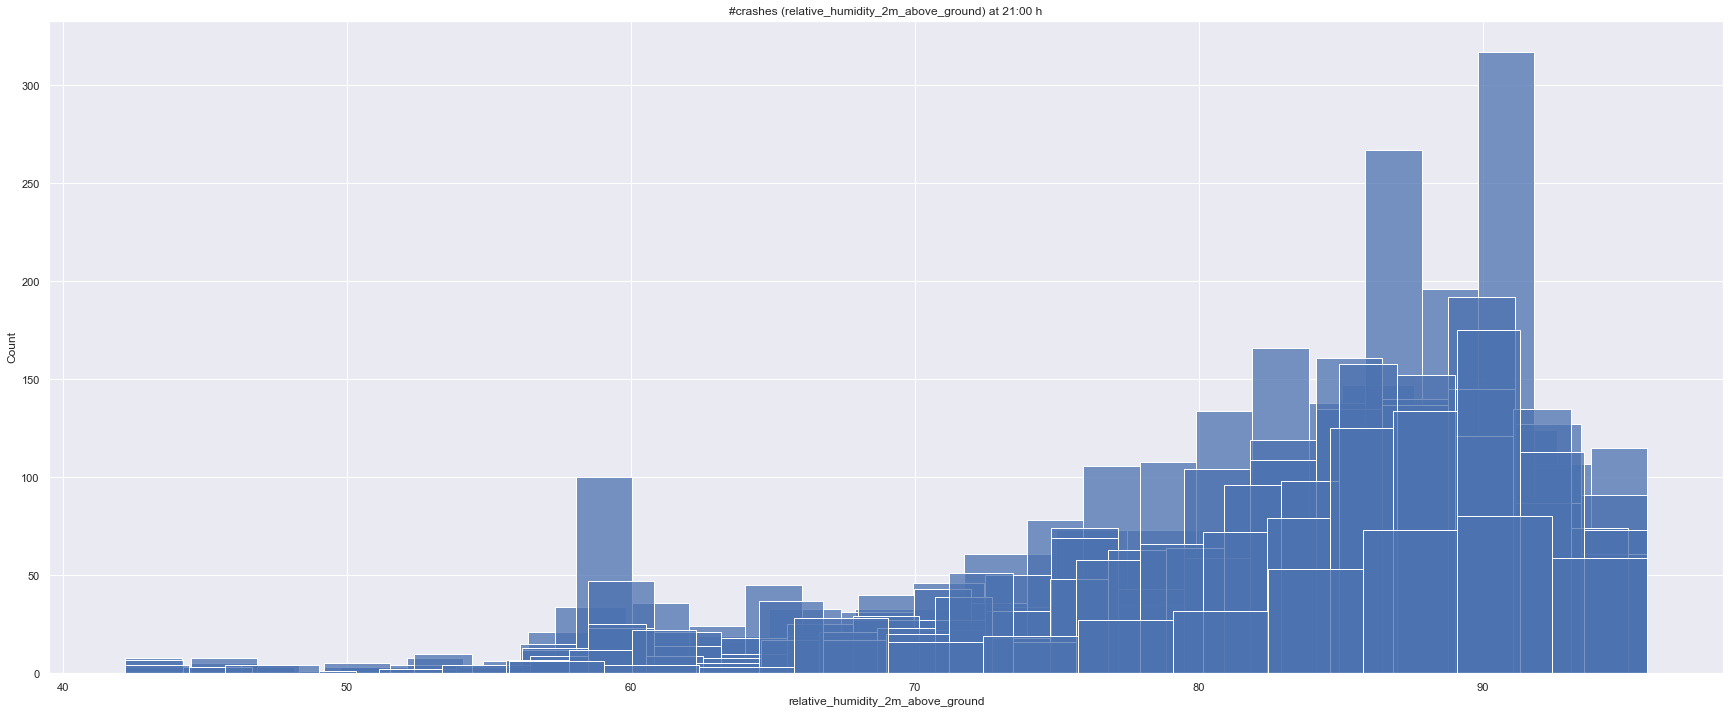

In [60]:
for i in range (0,24,3):
    d = X[(X['datetime'].dt.hour>=i) & (X['datetime'].dt.hour<=i+3)]
    sns.histplot(data=d['relative_humidity_2m_above_ground']).set_title('#crashes (relative_humidity_2m_above_ground) at '+str(i)+':00 h')

In [ ]:
#plot doesnt' work

/Users/dmitrii/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/dmitrii/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


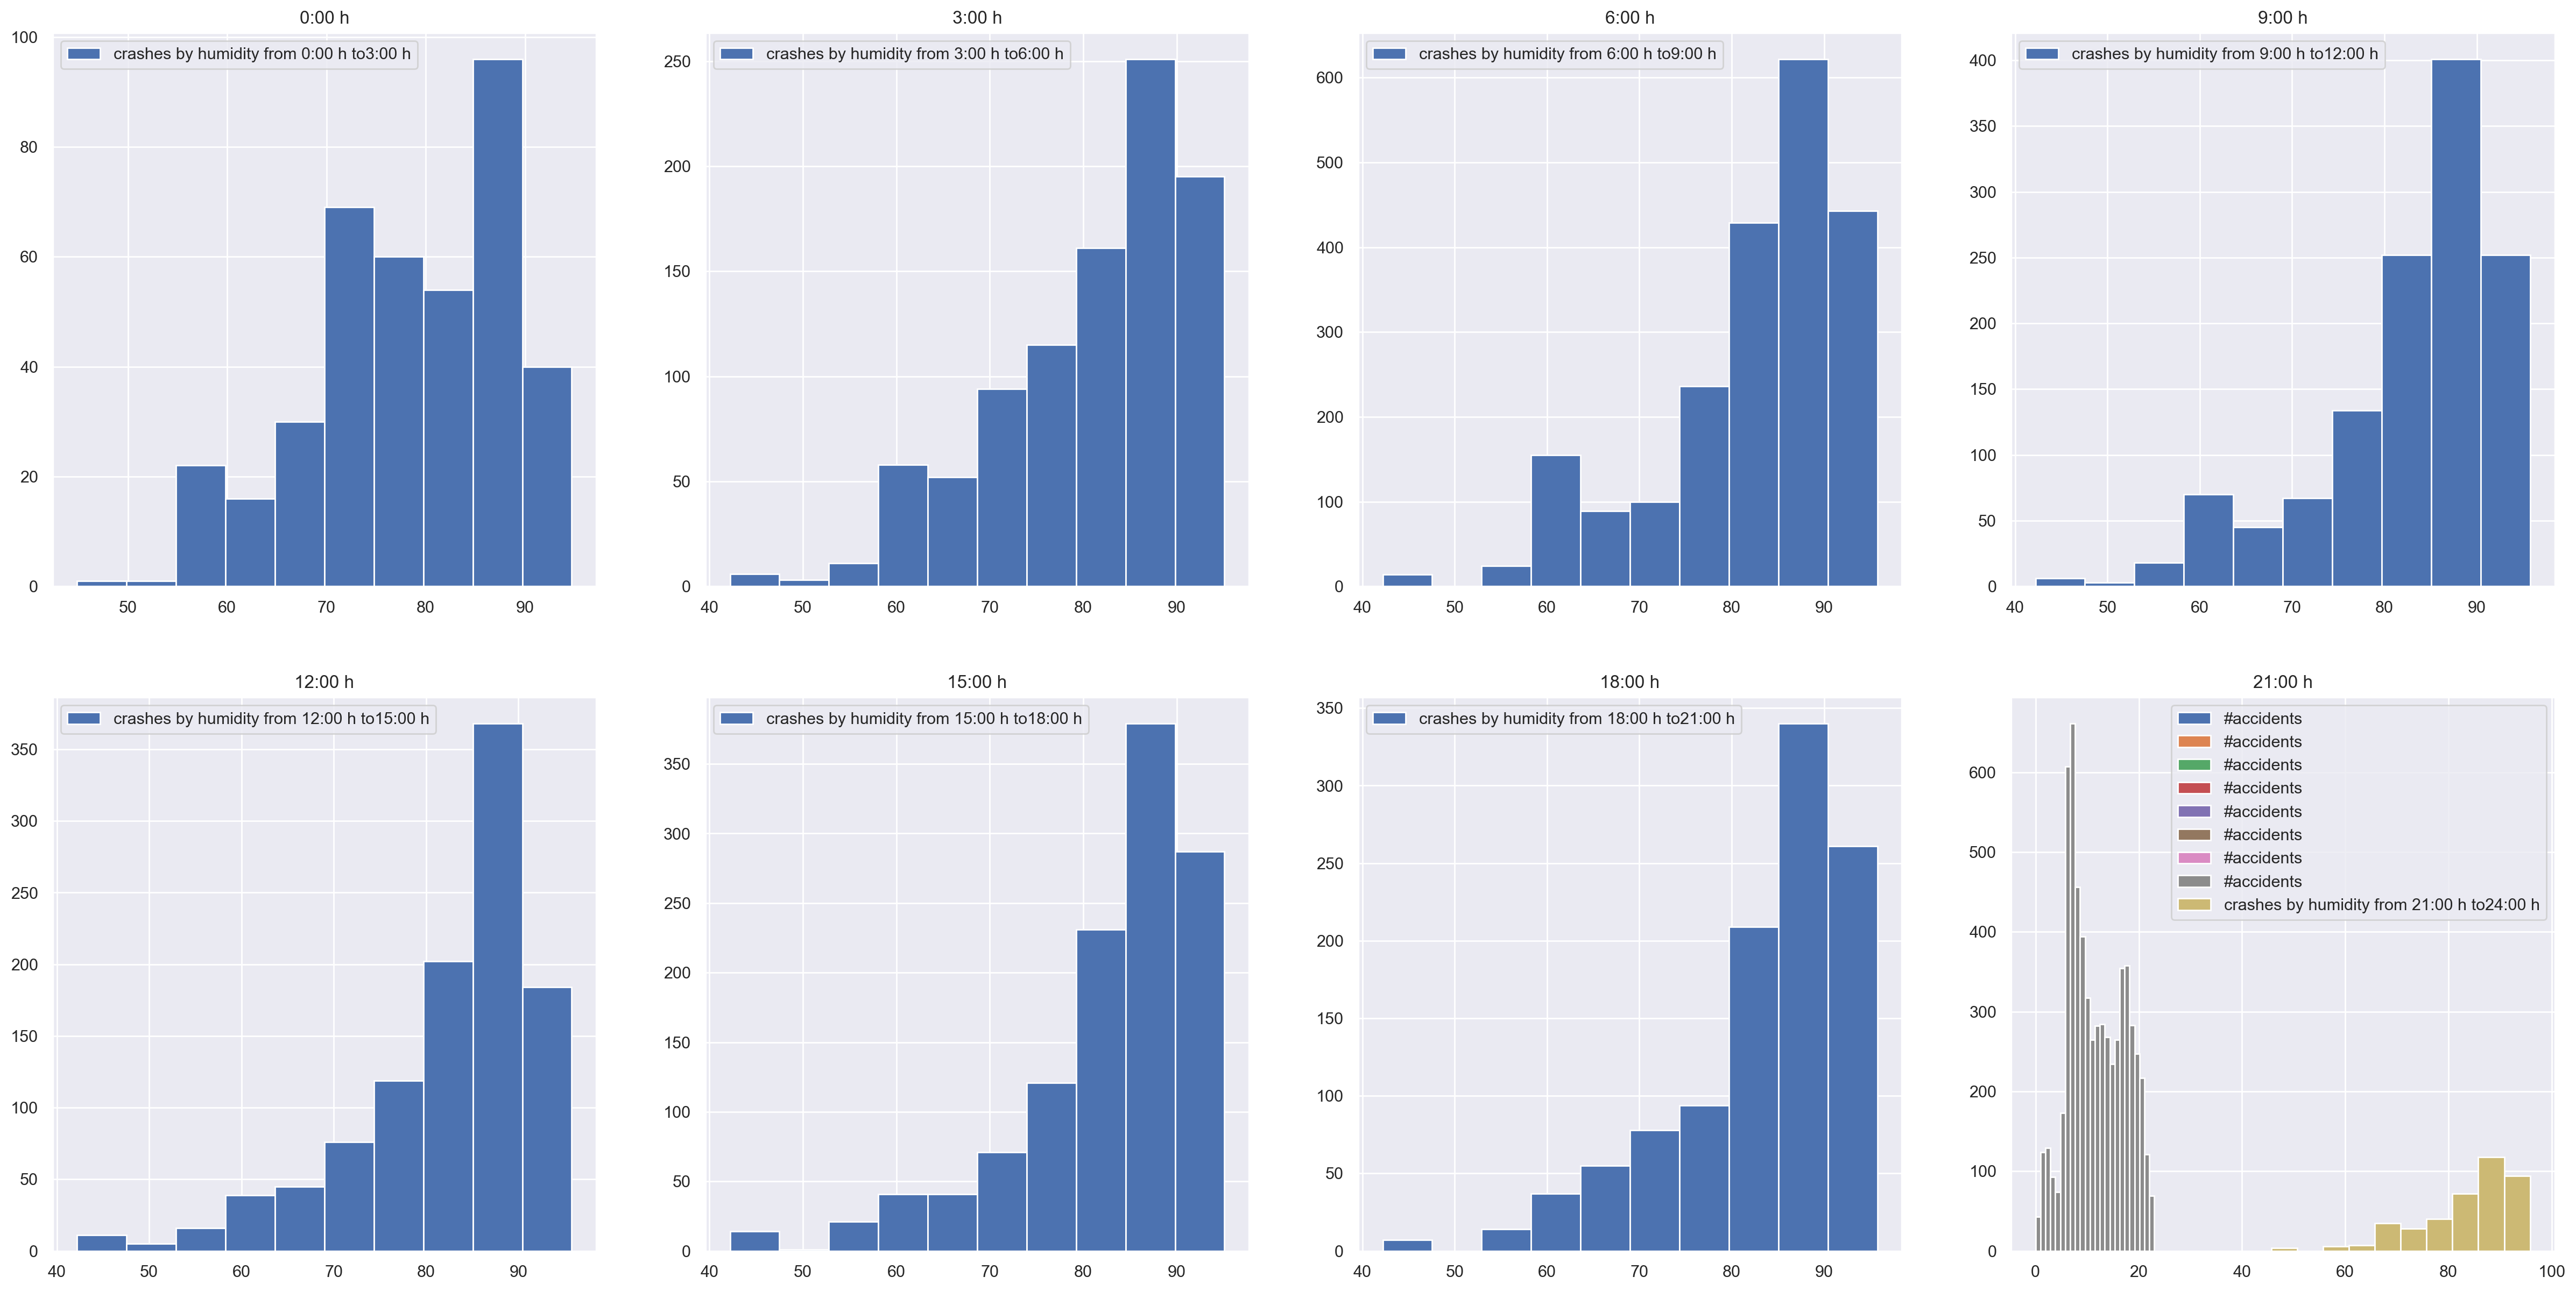

In [61]:
fig, axs = plt.subplots(2, 4, figsize=(30, 15), dpi=200)

j=[0,1,2,3,0,1,2,3]
k=0
for i in range(0,24,3):
    d = X[(X['datetime'].dt.hour>=i) & (X['datetime'].dt.hour<=i+3)]
    plt.hist(X.hour, label = '#accidents', bins = 24)
    q=j[k]
    axs[i//12, q].hist(d['relative_humidity_2m_above_ground'], label='crashes by humidity from '+str(i)+':00 h to'+str(i+3)+':00 h')
    axs[i//12, q].set_title(str(i)+':00 h')
    axs[i//12, q].legend()
    k=k+1
plt.savefig("kmeans comp.png")

In [118]:
#if there is no mistake, we observe small dependeca of humidity to date time

Text(0.5, 1.0, '#crashes (specific_humidity_2m_above_ground)')

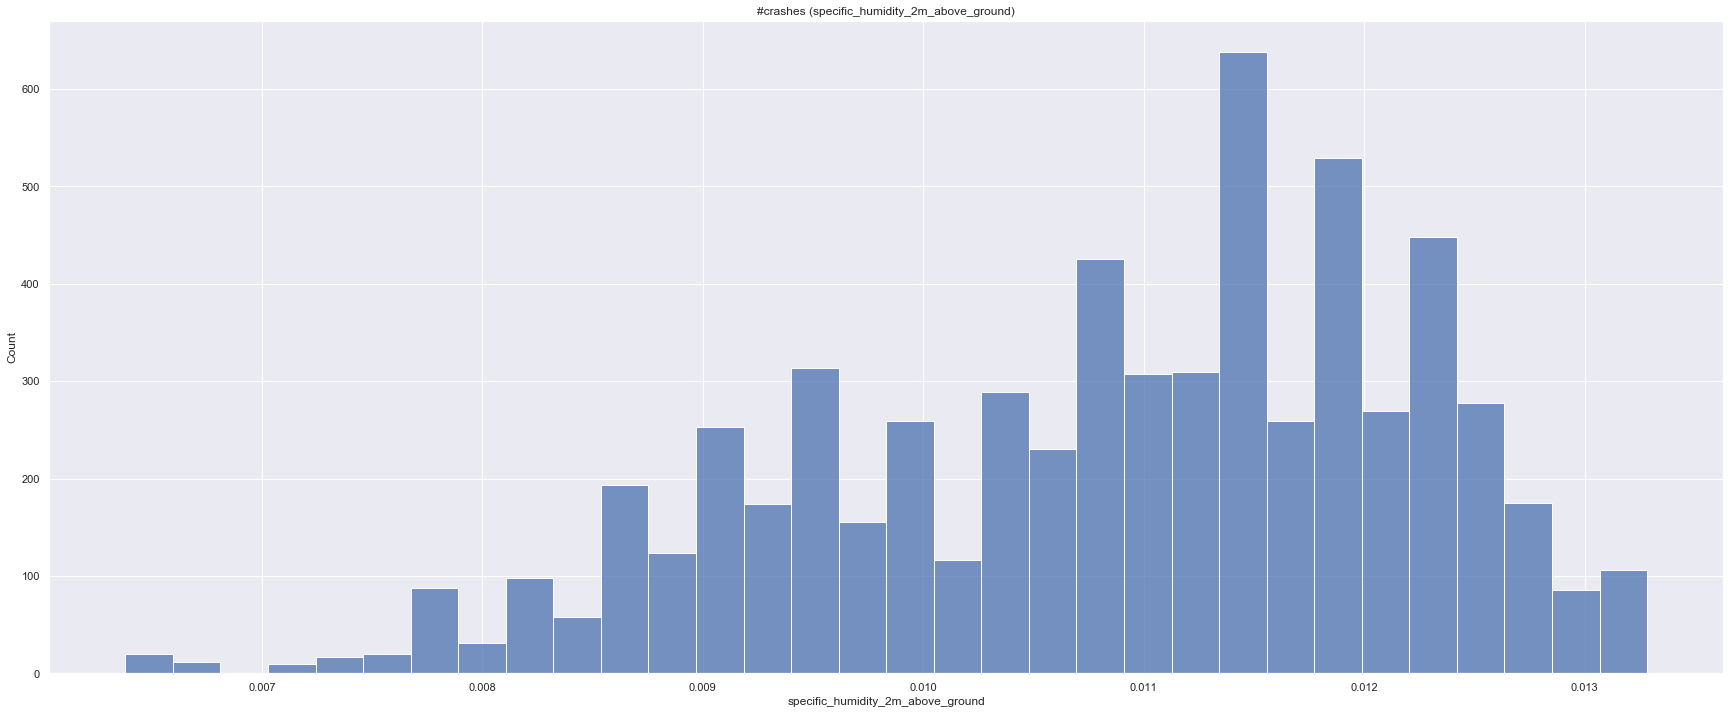

In [62]:
sns.histplot(data=X['specific_humidity_2m_above_ground']).set_title('#crashes (specific_humidity_2m_above_ground)')

Text(0.5, 1.0, '#crashes (temperature_2m_above_ground)')

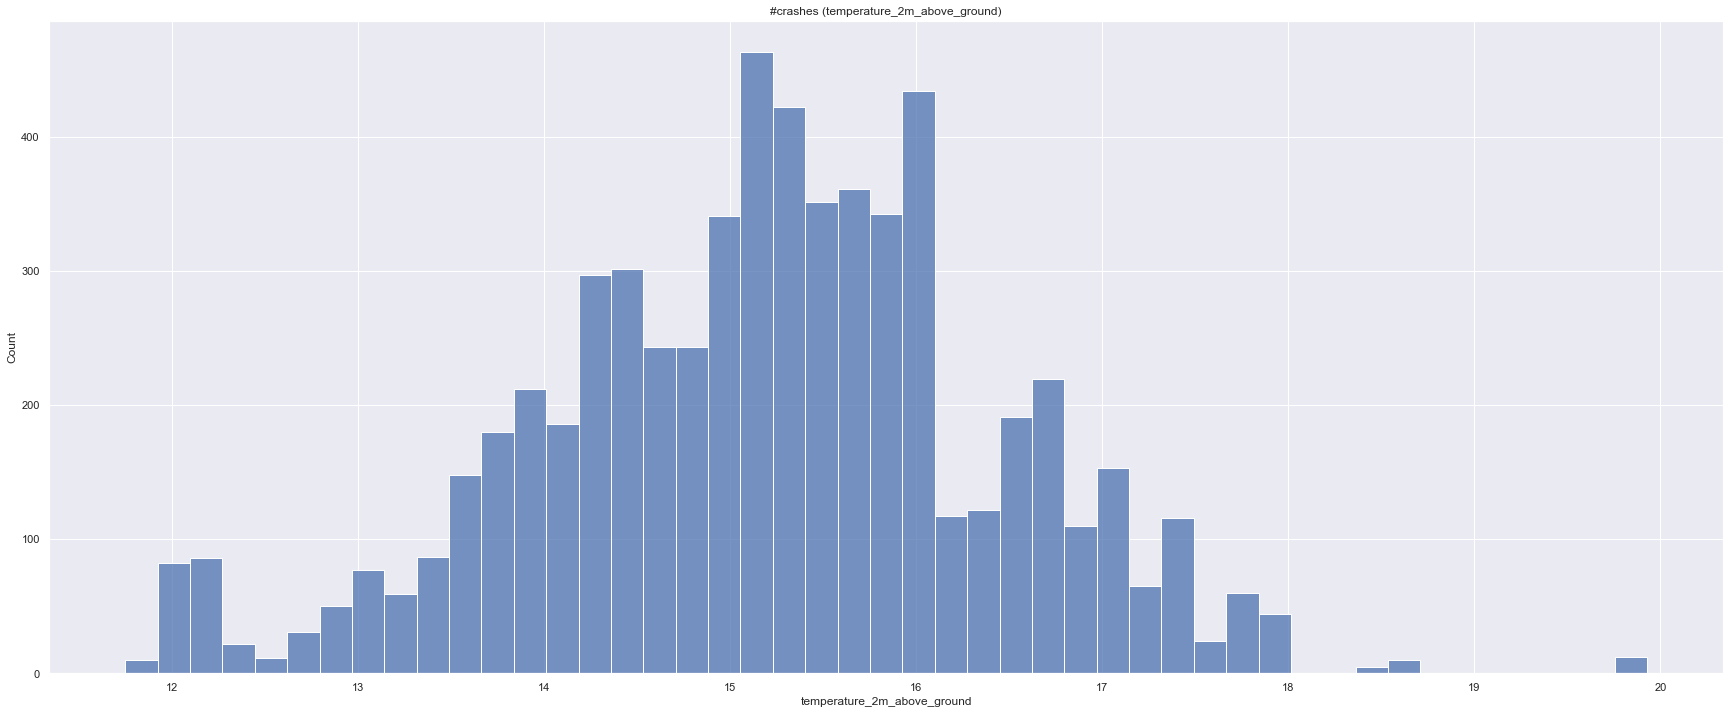

In [63]:
sns.histplot(data=X['temperature_2m_above_ground']).set_title('#crashes (temperature_2m_above_ground)')

In [119]:
#peak temp is lower than city average - probabably beacuse of more accidents in the morning and evening

Text(0.5, 1.0, '#crashes (u_component_of_wind_10m_above_ground)')

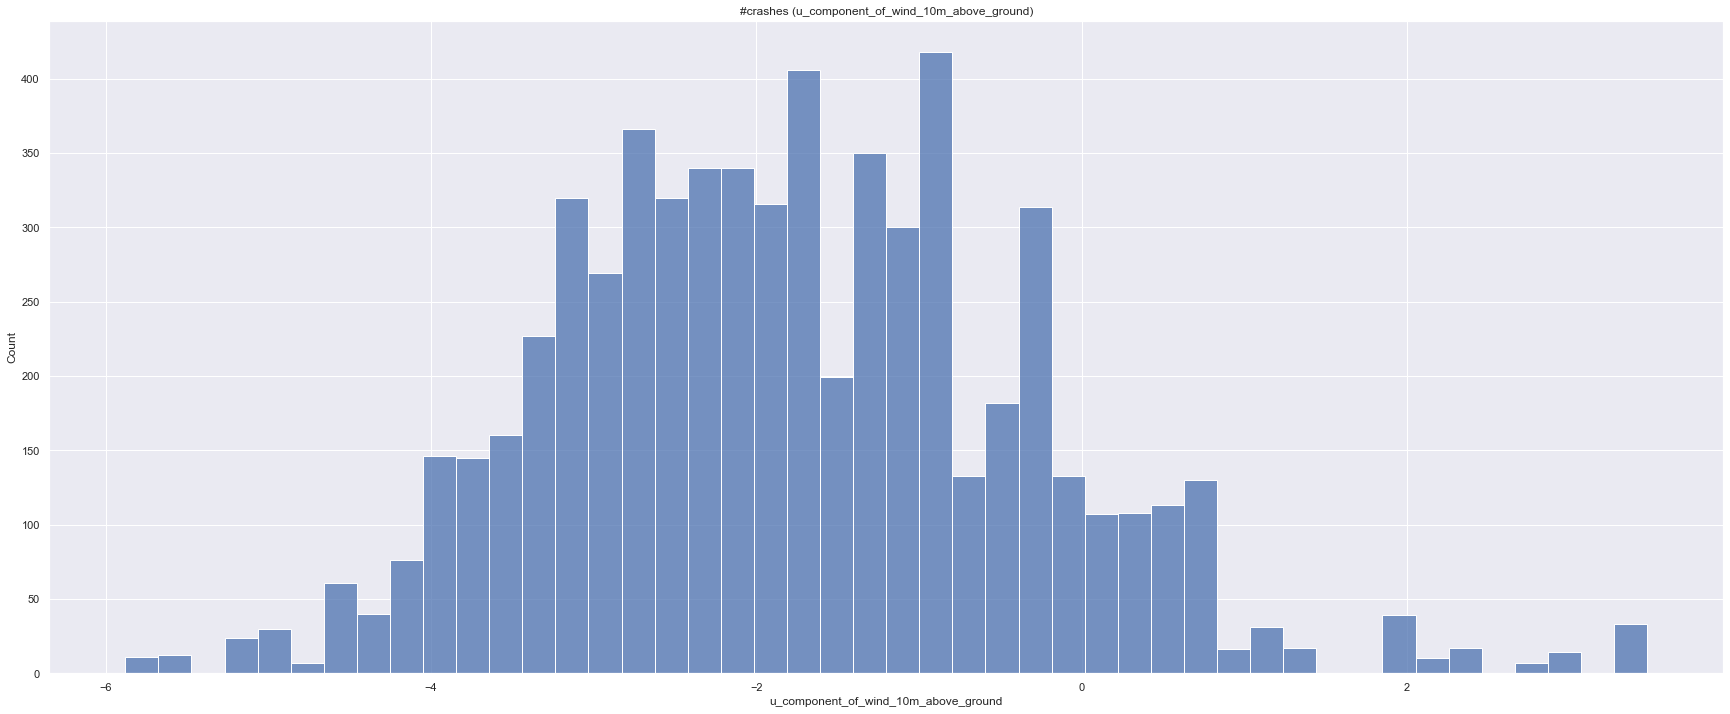

In [64]:
#nothing intresting
sns.histplot(data=X['u_component_of_wind_10m_above_ground']).set_title('#crashes (u_component_of_wind_10m_above_ground)')

Text(0.5, 1.0, '#crashes (v_component_of_wind_10m_above_ground)')

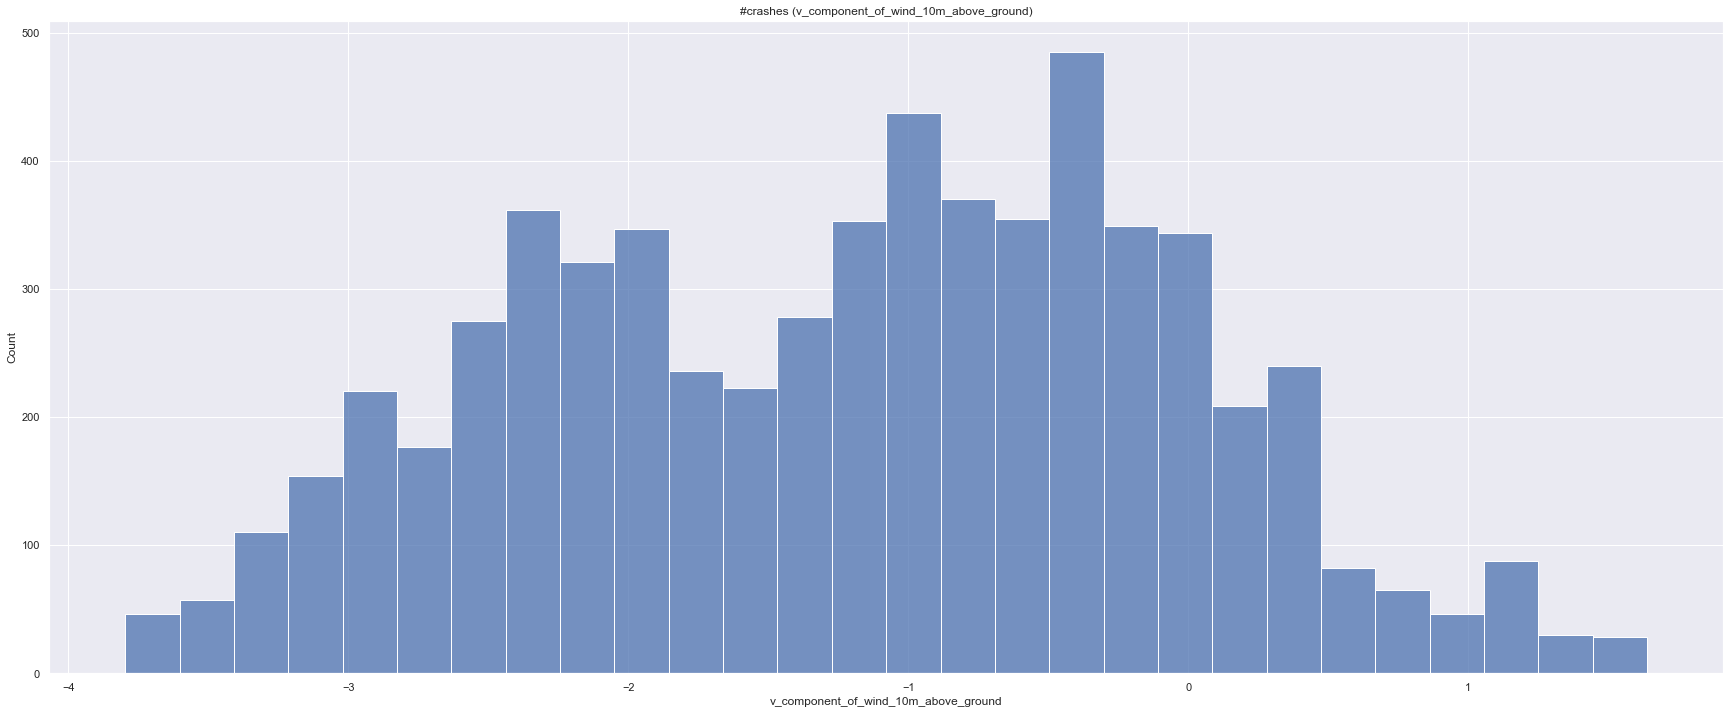

In [65]:
sns.histplot(data=X['v_component_of_wind_10m_above_ground']).set_title('#crashes (v_component_of_wind_10m_above_ground)')

In [ ]:
#nothing intresting?

In [66]:
#df.to_csv('preprocessed_df.csv', index=False)

In [67]:
df = pd.read_csv('Data/preprocessed_df.csv')

Let's create baseline of solution. There are 2 main aproches to solve problem, the first one is to create a model that ignores the date time features and the second solution is creating a model that takes in consideration this features.

# Baseline1 without time

In [68]:
from sklearn.cluster import KMeans

In [69]:
weather[weather.Date[0] == dff.Date]

/Users/dmitrii/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Date  precipitable_water_entire_atmosphere  \
0  2018-01-01                             24.100000   
1  2018-01-02                             27.362288   
2  2018-01-03                             30.246618   
3  2018-01-04                             33.010689   
4  2018-01-05                             27.250372   
5  2018-01-06                             24.300001   
6  2018-01-07                             23.800001   
7  2018-01-08                             20.600630   
8  2018-01-09                             21.786987   
9  2018-01-10                             22.000000   
10 2018-01-11                             27.700001   
11 2018-01-12                             24.600000   
12 2018-01-13                             23.413946   

    relative_humidity_2m_above_ground  specific_humidity_2m_above_ground  \
0                           72.700005                           0.009560   
1                           74.900002                           0.010463   
2                           86.599998                           0.011930   
3                           90.900002                           0.012780   
4                           82.413353                           0.011392   
5                           81.300003                           0.010660   
6                           74.735054                           0.009575   
7                           64.900002                           0.008180   
8                           72.597282                           0.009781   
9                           68.073692                           0.008876   
10                          83.375984                           0.011370   
11                          72.300003                           0.008960   
12                          76.900002                           0.009370   

    temperature_2m_above_ground  u_component_of_wind_10m_above_ground  \
0                     15.161493                             -0.012186   
1                     16.047998                              0.314543   
2                     15.838525                             -0.282732   
3                     16.169244                              0.211572   
4                     15.923456                              1.047275   
5                     15.124994                             -0.367690   
6                     14.816248                              0.544004   
7                     14.496667                             -0.003816   
8                     15.587091                             -0.600393   
9                     15.062982                             -0.884207   
10                    15.711389                             -1.524686   
11                    14.288538                             -0.075125   
12                    13.981531                             -2.300967   

    v_component_of_wind_10m_above_ground  
0                              -0.933914  
1                              -0.485459  
2                              -0.653965  
3                               0.908123  
4                              -0.037742  
5                              -1.720410  
6                              -0.813267  
7                              -1.861772  
8                              -0.693701  
9                              -1.480972  
10                             -0.749463  
11                             -0.900454  
12                             -1.773784

In [70]:
X = pd.merge(dff,weather, on = 'Date')

In [71]:
X.head(2)

uid            datetime  latitude  longitude       Date  \
0    1 2018-01-01 00:25:46 -1.188850  36.931382 2018-01-01   
1    2 2018-01-01 02:02:39 -0.662939  37.208730 2018-01-01   

   precipitable_water_entire_atmosphere  relative_humidity_2m_above_ground  \
0                                  24.1                          72.700005   
1                                  24.1                          72.700005   

   specific_humidity_2m_above_ground  temperature_2m_above_ground  \
0                            0.00956                    15.161493   
1                            0.00956                    15.161493   

   u_component_of_wind_10m_above_ground  v_component_of_wind_10m_above_ground  
0                             -0.012186                             -0.933914  
1                             -0.012186                             -0.933914

In [72]:
X['ddif'] = X['datetime']

In [73]:
for i in range(1, dff.shape[0]):
    X['ddif'][i] = (X['datetime'][i]-X['datetime'][i-1])

/Users/dmitrii/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/dmitrii/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [74]:
X.head(2)

uid            datetime  latitude  longitude       Date  \
0    1 2018-01-01 00:25:46 -1.188850  36.931382 2018-01-01   
1    2 2018-01-01 02:02:39 -0.662939  37.208730 2018-01-01   

   precipitable_water_entire_atmosphere  relative_humidity_2m_above_ground  \
0                                  24.1                          72.700005   
1                                  24.1                          72.700005   

   specific_humidity_2m_above_ground  temperature_2m_above_ground  \
0                            0.00956                    15.161493   
1                            0.00956                    15.161493   

   u_component_of_wind_10m_above_ground  v_component_of_wind_10m_above_ground  \
0                             -0.012186                             -0.933914   
1                             -0.012186                             -0.933914   

                  ddif  
0  2018-01-01 00:25:46  
1      0 days 01:36:53

There are we finding the 6 virtual ambulances locations by grouping over the crashes locations in to 6 groups. The simplest thing we can do is using a popular algorithm called KMeans to group over the crashes places. (Since our score function depends on distance)

In [75]:
kmeans = KMeans(n_clusters=6, random_state=54)
kmeans.fit((X[['latitude','longitude']]))


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=54, tol=0.0001, verbose=0)

In this baseline1 model we ignore the time feature, so this means we predict a fixed places for the 6 ambulances.

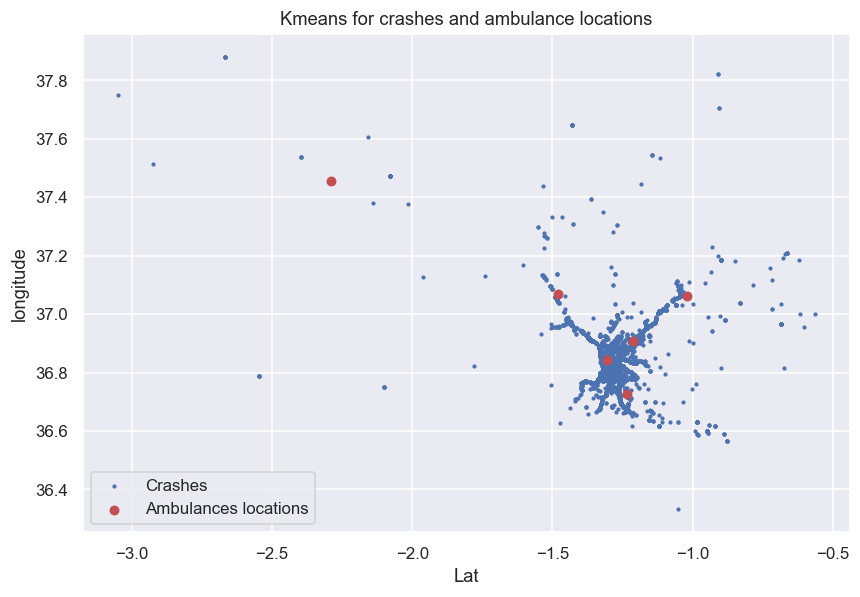

In [76]:

plt.figure(figsize=(9,6), dpi=110)

plt.scatter(X['latitude'],X['longitude'], s=3, label='Crashes' )
plt.scatter(x=kmeans.cluster_centers_[:,0], y=kmeans.cluster_centers_[:,1], color='r', s = 30, label='Ambulances locations')
plt.title('Kmeans for crashes and ambulance locations')
plt.xlabel("Lat")
plt.ylabel("longitude")
plt.legend()
plt.show()

In [77]:
import folium

In [78]:
map = folium.Map(location=[-1.18884981099406, 36.93138243675121], default_zoom_start=10)
folium.Marker(location=[-1.18884981099406, 36.93138243675121], icon=folium.Icon(color = 'red')).add_to(map)

In [79]:
X['latitude']

0      -1.188850
1      -0.662939
2      -0.662939
3      -1.288087
4      -1.188850
          ...   
6313   -1.262271
6314   -1.279468
6315   -1.322109
6316   -1.278589
6317   -1.211500
Name: latitude, Length: 6318, dtype: float64

In [80]:
lat=X['latitude']
lon=X['longitude']
lat[1]

-0.662938762534417

In [81]:
lat

0      -1.188850
1      -0.662939
2      -0.662939
3      -1.288087
4      -1.188850
          ...   
6313   -1.262271
6314   -1.279468
6315   -1.322109
6316   -1.278589
6317   -1.211500
Name: latitude, Length: 6318, dtype: float64

In [82]:
def color_change(k):
    if(km_labels[k] == 0):
        return('blue')
    if(km_labels[k] == 1):
        return('purple')
    if(km_labels[k] == 2):
        return('red')
    if(km_labels[k] == 3):
        return('orange')
    if(km_labels[k] == 4):
        return('yellow')
    

In [83]:
#fill_color=color_change(k)
#color=color_change(k)

In [84]:
kmeans_fixed = kmeans

In [85]:
map_2 = folium.Map(location=[-1.18884981099406, 36.93138243675121], default_zoom_start=10)
k=0
for i, j in zip(lat, lon):
    folium.CircleMarker(location=[i, j], radius = 1,fill_color='blue',color = 'blue', fill_opacity = 0.5 ).add_to(map_2)
    k=k+1


In [86]:
for i, j in zip(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1]):
    folium.CircleMarker(location=[i, j], radius = 3,fill_color='red',color = 'red', fill_opacity = 0.99 ).add_to(map_2)
    k=k+1

In [87]:
#looks cool)
map_2

## Making first submission csv

Printed the cluster centers, we see that it has 2 columns (the first one is latitude and the second one is longitude).

In [88]:
kmeans.cluster_centers_

array([[-1.23491483, 36.72512159],
       [-1.21207624, 36.90664441],
       [-1.47865223, 37.06834783],
       [-1.02141628, 37.06162761],
       [-2.28881419, 37.45654699],
       [-1.30417353, 36.84215825]])

We need to flatten them to be in a format similar to the submission file.

In [89]:
def flaten(q):
    coord = list(zip(q[:,0],q[:,1]))
    return [c for couple in coord for c in couple ]

In [90]:
ss.keys()

Index(['date', 'A0_Latitude', 'A0_Longitude', 'A1_Latitude', 'A1_Longitude',
       'A2_Latitude', 'A2_Longitude', 'A3_Latitude', 'A3_Longitude',
       'A4_Latitude', 'A4_Longitude', 'A5_Latitude', 'A5_Longitude'],
      dtype='object')

In [91]:
kr = flaten(kmeans.cluster_centers_)
for i in range(len(kr)):
    ss[ss.keys()[i+1]] = kr[i] #i+1 cause the first column is date
ss.head(2)

date  A0_Latitude  A0_Longitude  A1_Latitude  A1_Longitude  \
0 2019-07-01 00:00:00    -1.234915     36.725122    -1.212076     36.906644   
1 2019-07-01 03:00:00    -1.234915     36.725122    -1.212076     36.906644   

   A2_Latitude  A2_Longitude  A3_Latitude  A3_Longitude  A4_Latitude  \
0    -1.478652     37.068348    -1.021416     37.061628    -2.288814   
1    -1.478652     37.068348    -1.021416     37.061628    -2.288814   

   A4_Longitude  A5_Latitude  A5_Longitude  
0     37.456547    -1.304174     36.842158  
1     37.456547    -1.304174     36.842158

In [92]:
base1 = ss.copy()  #saving first baseline

In [93]:
base1.to_csv('base1.csv')

In [ ]:
#suprisingly, this is our best result

# Baseline2 with three hours time split clustering

To create baseline model 2, we split the training dataset into 8 chunks based on the hours of the crashes (grouped the crashes between 00.00 to 02.59 and from 03.00 to 05.59 so on) and create separate datasets then create seperated models based on those datasets.


In [94]:
for i in range(0,22,3):
    d = dff[(dff['datetime'].dt.hour>=i) & (dff['datetime'].dt.hour<=i+3)]
    kmeans = KMeans(n_clusters=6, random_state=54).fit(d[['latitude','longitude']])
    t = flaten(kmeans.cluster_centers_)
    ss.loc[ss['date'].dt.hour == i, ['A0_Latitude','A0_Longitude',
                                     'A1_Latitude','A1_Longitude','A2_Latitude','A2_Longitude',
                                     'A3_Latitude','A3_Longitude','A4_Latitude','A4_Longitude',
                                     'A5_Latitude','A5_Longitude']] = t
    

In [95]:
ss.head(2)

date  A0_Latitude  A0_Longitude  A1_Latitude  A1_Longitude  \
0 2019-07-01 00:00:00    -1.370847     36.943975    -2.497671     37.788891   
1 2019-07-01 03:00:00    -1.246306     36.734972    -2.473397     37.593694   

   A2_Latitude  A2_Longitude  A3_Latitude  A3_Longitude  A4_Latitude  \
0    -1.246829     36.715524    -1.293232     36.830811    -0.912302   
1    -0.996639     37.044251    -1.310685     36.842698    -1.220501   

   A4_Longitude  A5_Latitude  A5_Longitude  
0     37.067283    -1.195523     36.924074  
1     36.895476    -1.466711     37.076139

In [96]:
ss.to_csv('base2.csv')

# Comparison b1 and b2 model

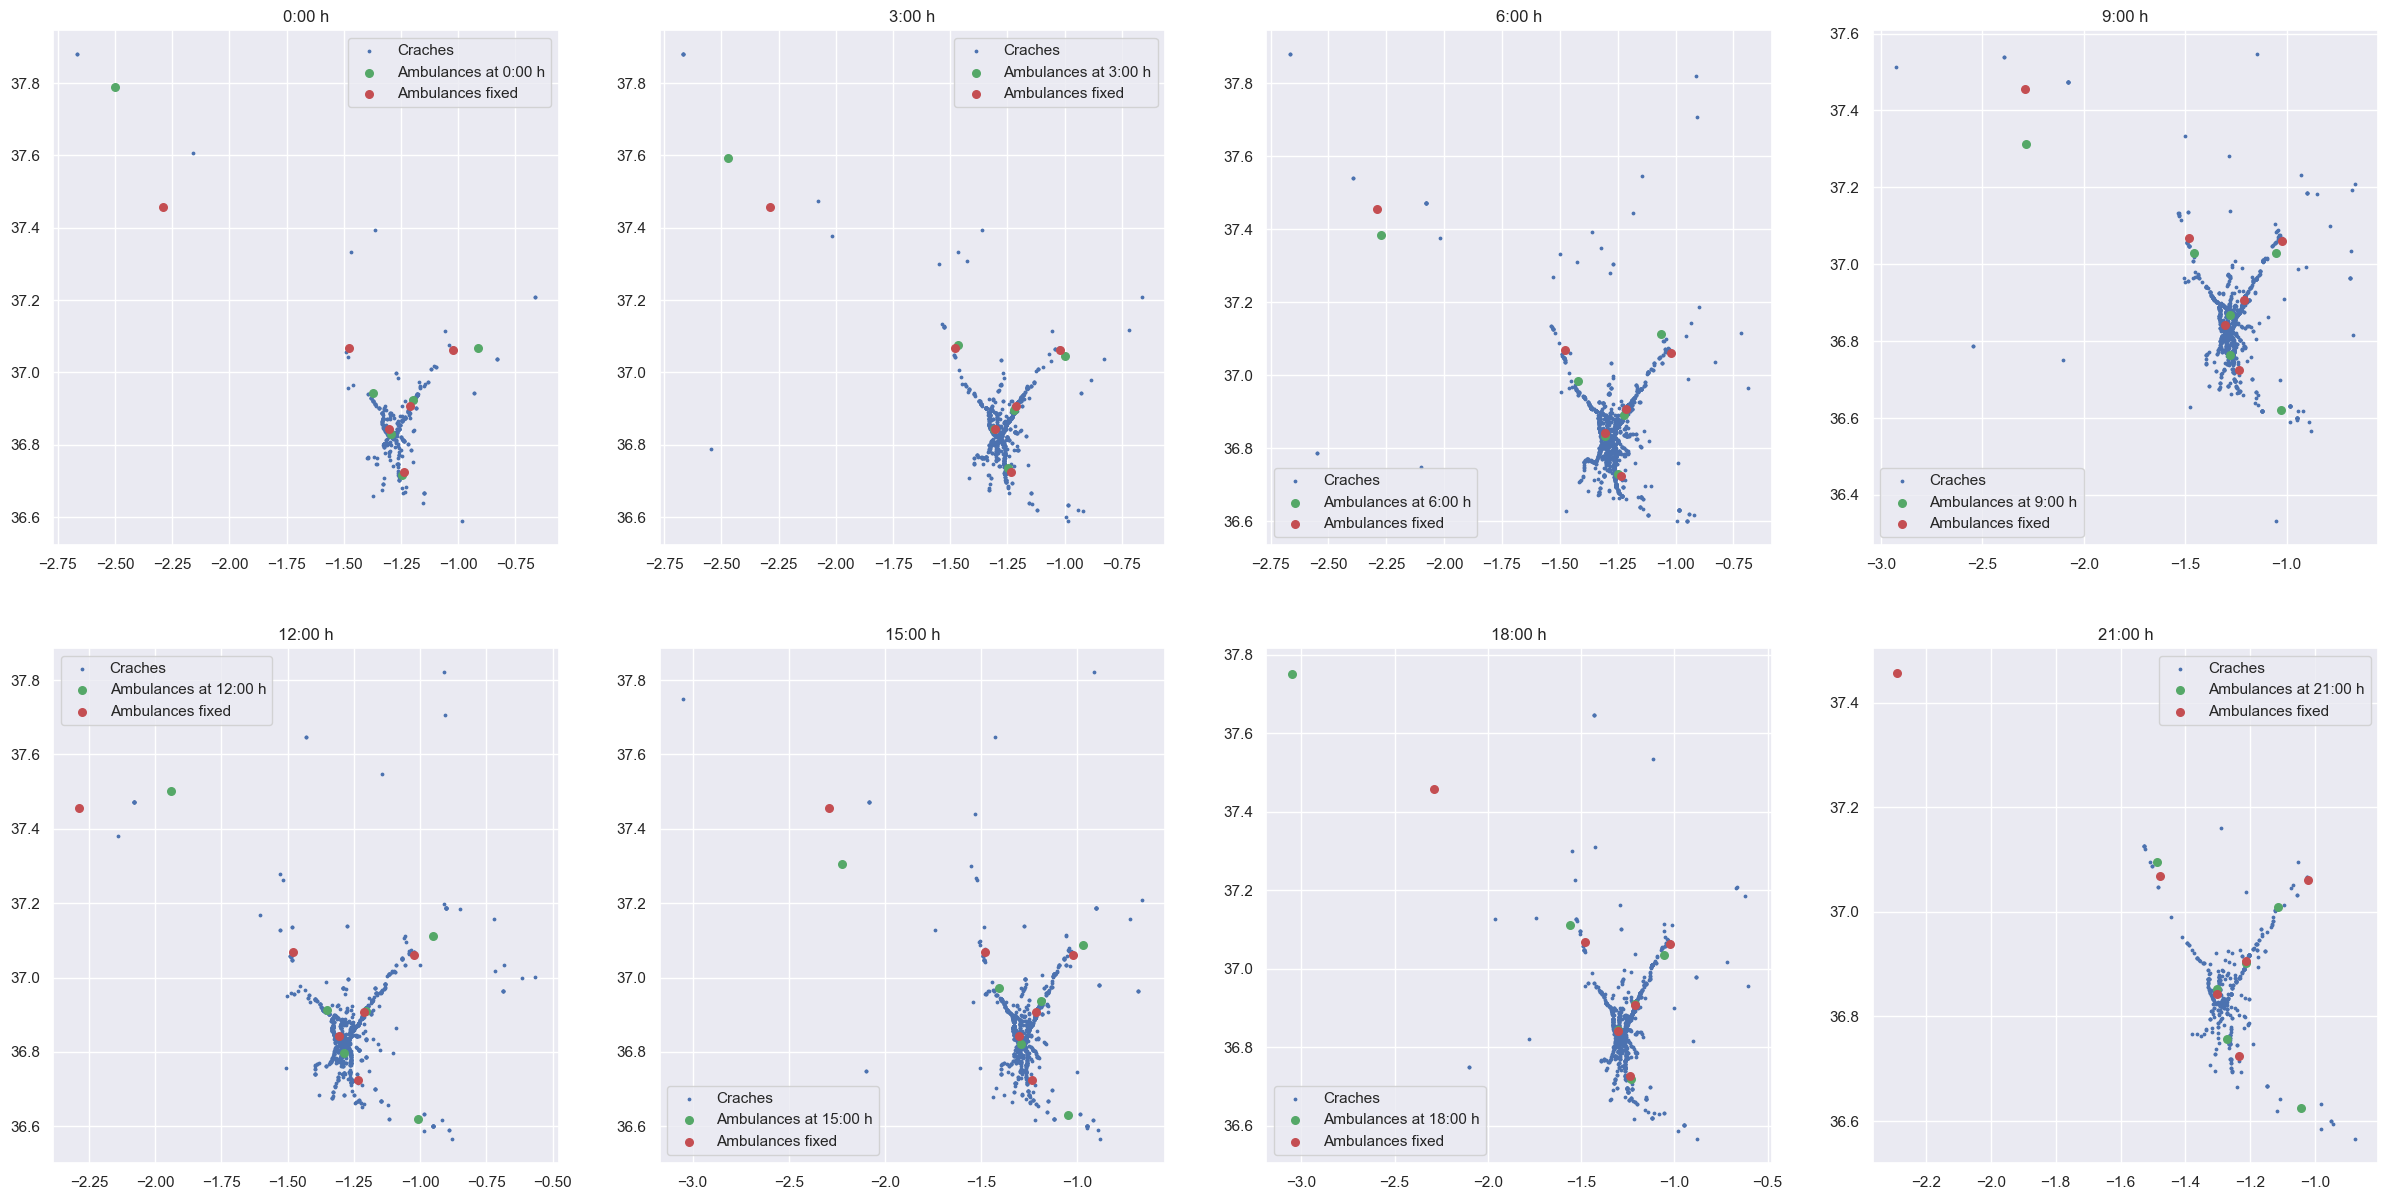

In [97]:
fig, axs = plt.subplots(2, 4, figsize=(30, 15), dpi=100)
models = []
j=[0,1,2,3,0,1,2,3]
k=0
for i in range(0,24,3):
    d = dff[(dff['datetime'].dt.hour>=i) & (dff['datetime'].dt.hour<=i+3)]
    kmeans = KMeans(n_clusters=6, random_state=54).fit(d[['latitude','longitude']])
    models.append(kmeans)
    q=j[k]
    axs[i//12, q].scatter(d['latitude'],d['longitude'],s=3, label='Craches')
    axs[i//12, q].set_title(str(i)+':00 h')
    axs[i//12, q].scatter(x=kmeans.cluster_centers_[:,0], y=kmeans.cluster_centers_[:,1], color='g',label='Ambulances at '+str(i)+':00 h',s=30)
    axs[i//12, q].scatter(x=kmeans_fixed.cluster_centers_[:,0], y=kmeans_fixed.cluster_centers_[:,1], color='r',label='Ambulances fixed',s=30)
    axs[i//12, q].legend()
    k=k+1
plt.savefig("kmeans comp.png")

In [98]:
for t,k in enumerate(models):
    print("from",t*3,"to",(t*3)+3)
    for i in range(6):
        print("center",i,(k.cluster_centers_[i,0],k.cluster_centers_[i,1])," :",np.sum(k.labels_== i))
    print("___________")
    print()

from 0 to 3
center 0 (-1.3708469490865973, 36.94397461478787)  : 37
center 1 (-2.49767067091915, 37.788890601409804)  : 3
center 2 (-1.2468293958561238, 36.71552351137943)  : 42
center 3 (-1.293232331574883, 36.83081121533449)  : 206
center 4 (-0.9123015427482564, 37.06728259602676)  : 13
center 5 (-1.1955226759800388, 36.924074257465385)  : 88
___________

from 3 to 6
center 0 (-1.246306301396063, 36.73497231816524)  : 168
center 1 (-2.473396833173724, 37.59369424437173)  : 7
center 2 (-0.9966392350033985, 37.044250537674046)  : 21
center 3 (-1.310684922649945, 36.84269783556278)  : 474
center 4 (-1.220501061824614, 36.895475569584654)  : 252
center 5 (-1.466711112148987, 37.07613887234423)  : 25
___________

from 6 to 9
center 0 (-1.220973033426937, 36.891995142399935)  : 502
center 1 (-1.2477878505400695, 36.73073388857535)  : 465
center 2 (-2.27248665567963, 37.38414414470723)  : 14
center 3 (-1.4214639821565729, 36.98367329232584)  : 109
center 4 (-1.0633130751641477, 37.113370484

In [99]:
df = pd.read_csv('Data/preprocessed_df.csv')

In [100]:
segment_ids = road_surveys['segment_id'].unique()

In [101]:
dates = pd.to_datetime(ss['date'].apply(lambda x: x.date()))
dates = dates.unique()

In [102]:
df1 = pd.read_csv('Data/Train.csv', parse_dates=['datetime'])

In [103]:
df1

uid            datetime  latitude  longitude
0        1 2018-01-01 00:25:46 -1.188850  36.931382
1        2 2018-01-01 02:02:39 -0.662939  37.208730
2        3 2018-01-01 02:31:49 -0.662939  37.208730
3        4 2018-01-01 03:04:01 -1.288087  36.826583
4        5 2018-01-01 03:58:49 -1.188850  36.931382
...    ...                 ...       ...        ...
6313  6314 2019-06-29 18:52:44 -1.262271  36.726540
6314  6315 2019-06-30 09:57:44 -1.279468  36.790449
6315  6316 2019-06-30 12:02:14 -1.322109  36.825248
6316  6317 2019-06-30 16:59:14 -1.278589  36.816518
6317  6318 2019-06-30 20:06:14 -1.211500  36.907635

[6318 rows x 4 columns]

In [104]:
df1['datetime'] = pd.to_datetime(df1['datetime'])


In [105]:
df1['Date'] = pd.to_datetime(weather['Date'].dt.date)

In [106]:
df1.head()

uid            datetime  latitude  longitude       Date
0    1 2018-01-01 00:25:46 -1.188850  36.931382 2018-01-01
1    2 2018-01-01 02:02:39 -0.662939  37.208730 2018-01-02
2    3 2018-01-01 02:31:49 -0.662939  37.208730 2018-01-03
3    4 2018-01-01 03:04:01 -1.288087  36.826583 2018-01-04
4    5 2018-01-01 03:58:49 -1.188850  36.931382 2018-01-05

In [107]:
df1['Hour'] = pd.to_datetime(df1['datetime'].dt.hour)

In [108]:
weather = pd.read_csv('Data/Weather_Nairobi_Daily_GFS.csv', parse_dates=['Date'])
weather.shape

(731, 7)

In [109]:
weather['Date'] = pd.to_datetime(weather['Date'].dt.date)
X = pd.merge(df1,weather, on = 'Date')

In [110]:
X.shape

(731, 12)

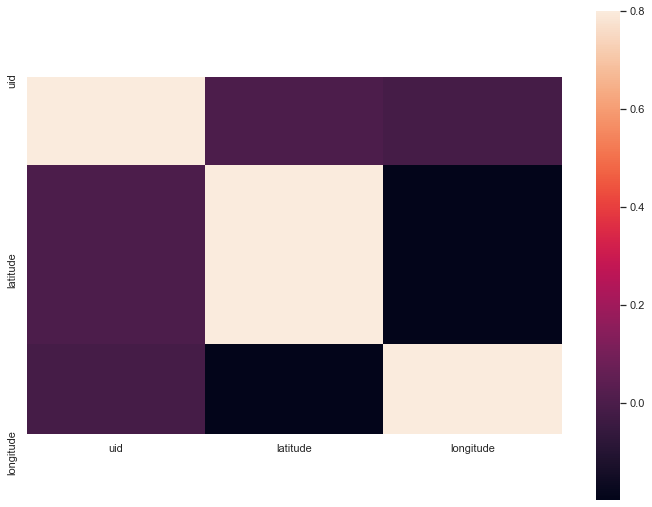

In [111]:
corrmat = df1.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.savefig('corr_matrix.png')

In [112]:
df_road.head()

uid       Date segment_id  precipitable_water_entire_atmosphere  \
0    1 2018-01-01       58_1                                  24.1   
1    1 2018-01-01       58_1                                  24.1   
2    1 2018-01-01       58_1                                  24.1   
3    1 2018-01-01       58_1                                  24.1   
4    5 2018-01-01       58_1                                  24.1   

   relative_humidity_2m_above_ground  specific_humidity_2m_above_ground  \
0                          72.700005                            0.00956   
1                          72.700005                            0.00956   
2                          72.700005                            0.00956   
3                          72.700005                            0.00956   
4                          72.700005                            0.00956   

   temperature_2m_above_ground  u_component_of_wind_10m_above_ground  \
0                    15.161493                             -0.012186   
1                    15.161493                             -0.012186   
2                    15.161493                             -0.012186   
3                    15.161493                             -0.012186   
4                    15.161493                             -0.012186   

   v_component_of_wind_10m_above_ground         0  ...  80_97_61_65_12  \
0                             -0.933914 -2.398031  ...             0.0   
1                             -0.933914 -2.398031  ...             1.0   
2                             -0.933914 -2.668842  ...             0.0   
3                             -0.933914 -2.668842  ...             1.0   
4                             -0.933914 -2.398031  ...             0.0   

   80_97_61_65_15  80_97_61_65_16  80_97_61_39_0  80_97_61_39_10  \
0             1.0             1.0            0.0             0.0   
1             0.0             0.0            1.0             0.0   
2             1.0             1.0            0.0             0.0   
3             0.0             0.0            1.0             0.0   
4             1.0             1.0            0.0             0.0   

   80_97_61_39_11  80_97_61_39_12  80_97_61_39_15  80_97_61_39_16  count  
0             0.0             1.0             0.0             0.0    208  
1             0.0             0.0             1.0             1.0    208  
2             0.0             1.0             0.0             0.0    208  
3             0.0             0.0             1.0             1.0    208  
4             0.0             1.0             0.0             0.0    208  

[5 rows x 242 columns]

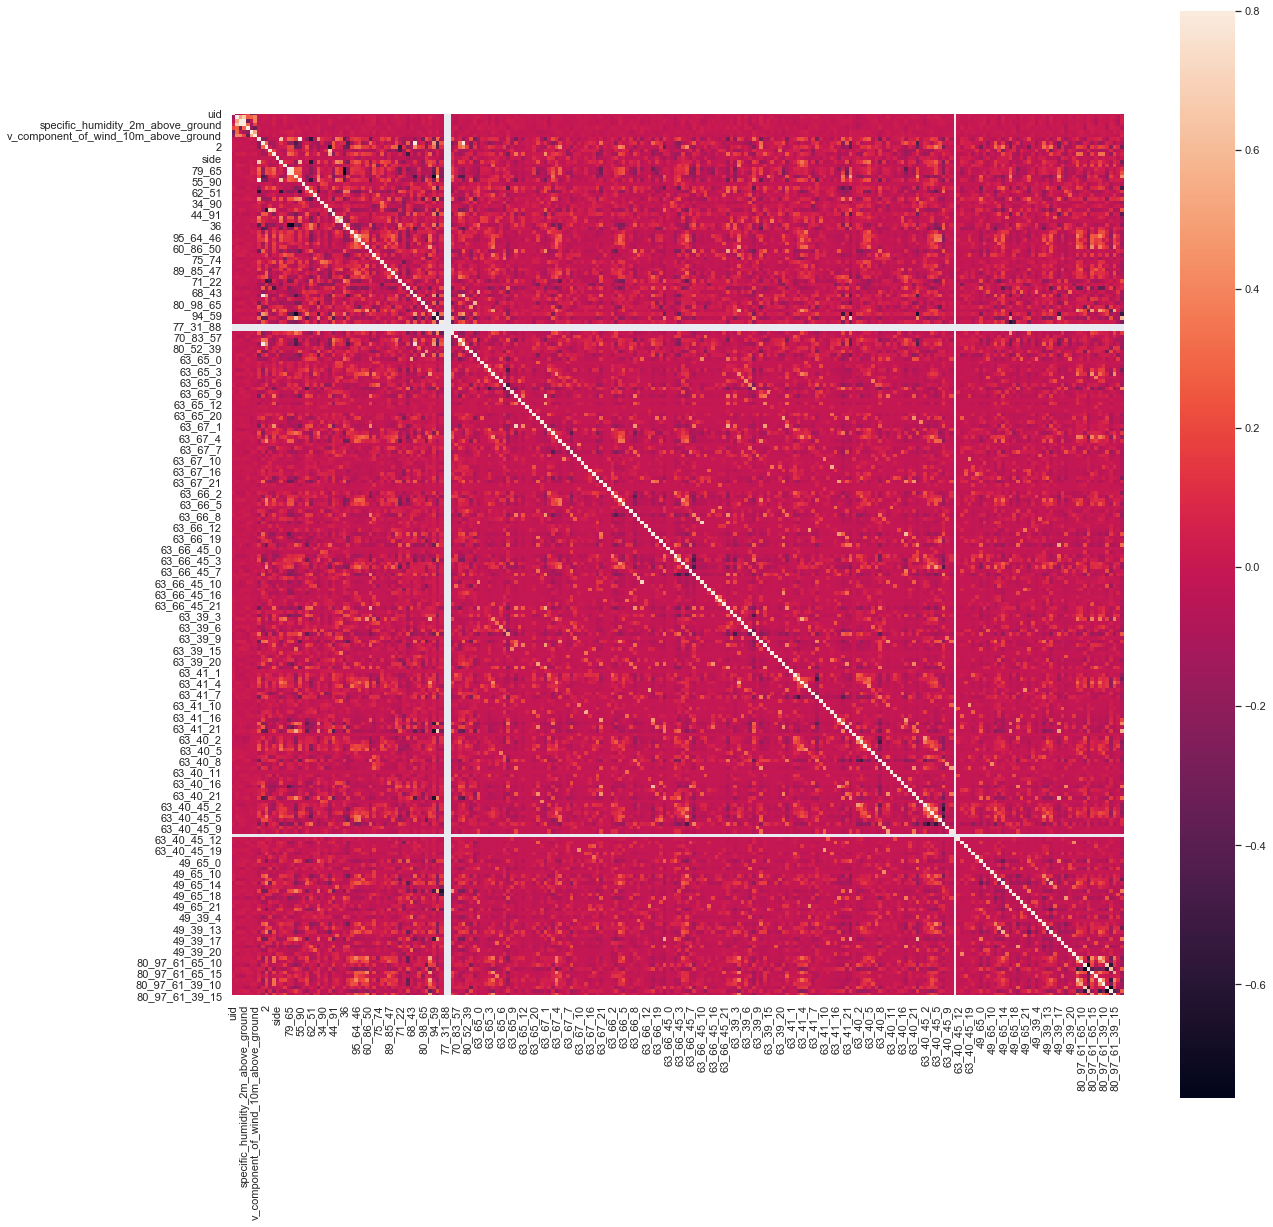

In [113]:
corrmat = df_road.corr()
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.savefig('corr_matrix.png')
#useless

In [ ]:
#useless, but looks nice